# Predictive Modeling of Asset Returns: AssetReturnPrediction

**Author:** Cem Akkus  
**Institution:** Ludwig-Maximilians-Universität München  
**Date:** 14.07.2024

## Table of Contents
1. [Data Preparation](#data-prep)  
    1.1. [Modules, Seeds & Hyperparameters](#module)  
    1.2. [Function Definitions](#functions)  
    1.3. [Data Import](#loading)  
    1.4. [Feature Engineering for LSTM](#feature)  
    1.5. [Pre-Processing for ARIMA](#pre-arima)  
    1.6. [Pre-Processing for LSTM](#pre-lstm)  
2. [LSTM & ARIMA](#arima-lstm)  
    2.1. [LSTM Predictions](#lstm)  
    2.2. [ARIMA Predictions](#arima)  
    2.3. [Comparison of ARIMA & LSTM Predictions](#comp-arima-lstm)  
3. [LSTM_NAD](#lstmnad)  
    3.1. [Pre-Processing for LSTM_NAD](#pre-lstmnad)  
    3.2. [LSTM_NAD Predictions](#pred-lstmnad)  
    3.3. [Comparison of ARIMA, LSTM & LSTM_NAD Predictions](#comp-lstmnad)
4.  [LSTM_NHE](#lstmnhe)  
    4.1. [Data Preparation for Fine-Tuning](#pre-lstmnhe)  
    4.2. [Data Preparation after Fine-Tuning](#pre-lstmnhe2)  
    4.3. [LSTM_NHE Predictions](#pred-lstmnhe)    
    4.4. [Comparison of ARIMA, LSTM, LSTM_NAD, LSTM_NHE Predictions](#comp-lstmnhe)

## 1. Data Preparation
<a name="data-prep"></a>

### 1.1. Modules, Seeds & Hyperparameters
<a name="module"></a>

In [2]:
import random
import os
import math
import ast
import warnings
import io
from contextlib import redirect_stdout

import pandas as pd
import numpy as np
from numpy.random import seed 
import tensorflow as tf


import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import seaborn as sns
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima
from kerastuner.tuners import RandomSearch
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras import optimizers 
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping


/var/folders/d3/5_l3h7cd1c98_xcdw8_wgkbh0000gn/T/ipykernel_4962/2506401758.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/var/folders/d3/5_l3h7cd1c98_xcdw8_wgkbh0000gn/T/ipykernel_4962/2506401758.py:24: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [3]:
# Setting seeds for reproducability
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
# General hyperparameter for lstm
input_steps = 20
output_steps = 1 #1-day ahead predictions

In [5]:
# # General hyperparameter for lstm
# input_steps = 20
# output_steps = 5 #5-day ahead predictions

### 1.2. Functions Definitions
<a name="functions"></a>

In [6]:
# Function to create two sequences out of which one predicts the other (inspired by: https://github.com/krishnaik06/Time-Series-Forecasting/blob/master/UnivariateTimeSeries.ipynb)
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
# Function to test stationarity
def test_stationarity(time_series):
    print('Results of dickey fuller test:')
    adft = adfuller(time_series,autolag='AIC')
    #dft outputs values without definitions -> manually naming them
    output = pd.Series(adft[0:4],index=['Test Statistic','p-value','Number of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [8]:
# Function for arima prediction
def arima_model(train_data, test_data, order, output_steps):
    # Fit ARIMA model
    model_arima = ARIMA(train_data, order=order)
    fitted_model = model_arima.fit()
    
    # ARIMA prediction
    history = [x for x in train_data]
    predictions = []
    for t in range(len(test_data)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast(steps=output_steps)
        yhat = output[output_steps - 1]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
    
    # Flat predictions
    predicted_flat = [float(i) for i in predictions]
    
    # Performance review
    mse = mean_squared_error(test_data, predicted_flat)
    mae = mean_absolute_error(test_data, predicted_flat)
    rmse = math.sqrt(mse)
    
    return mse, mae, rmse, predicted_flat, fitted_model.summary()

In [9]:
# Function to create an LSTM model with dynamic hyperparameters
def create_lstm_model(input_steps, n_features, units, learning_rate):
    model = tf.keras.Sequential([
        LSTM(units=units, return_sequences=False, input_shape=(input_steps, n_features + 1)),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [10]:
# Function to capture model summary
def get_model_summary(model):
    with io.StringIO() as buf, redirect_stdout(buf):
        model.summary()
        return buf.getvalue()  # Returns the model summary as a string.

In [11]:
# Function to execute random search
def lstm_hp_random_search(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name, epochs, max_trials, patience):
    def model_builder(hp):
        units = hp.Int('units', min_value=8, max_value=128, step=8)
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        model = create_lstm_model(input_steps, n_features, units, learning_rate)
        return model

    tuner = RandomSearch(
        model_builder,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=1,
        directory=f'./lstm_tuning/{company_name}',
        project_name='lstm_hyperparameter_tuning_random',
        overwrite=True
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
    tuner.search(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[early_stopping])

    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    return best_hyperparameters

In [12]:
# Function training LSTM model with best hyperparameters
def train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features, epochs, patience, verbose):
    units = best_hyperparameters.get('units')
    learning_rate = best_hyperparameters.get('learning_rate')
    model = create_lstm_model(input_steps, n_features, units, learning_rate)

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
    history = model.fit(X_train, Y_train, epochs=epochs, verbose=verbose, validation_data=(X_val, Y_val), callbacks=[early_stopping])

    return model, history

### 1.3. Data Import
<a name="loading"></a>

In [13]:
# Load CSV file into dataframe
data_dict = {}

# Define the directory where the CSV files are saved
directory = '/Users/cemakkus/PycharmProjects/Master/data/'

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.startswith('export_') and filename.endswith('.csv'):
        ticker = filename.replace('export_', '').replace('.csv', '')
        
        file_path = os.path.join(directory, filename)
        
        df = pd.read_csv(file_path)
        data_dict[ticker] = df.iloc[output_steps:] 
        
        print(f'DataFrame for {ticker} loaded from {file_path}')

data_dict = {k: data_dict[k] for k in sorted(data_dict)}


DataFrame for SAF_PA loaded from /Users/cemakkus/PycharmProjects/Master/data/export_SAF_PA.csv
DataFrame for MUV2_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_MUV2_DE.csv
DataFrame for ISP_MI loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ISP_MI.csv
DataFrame for ASML_AS loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ASML_AS.csv
DataFrame for BN_PA loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BN_PA.csv
DataFrame for BBVA_MC loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BBVA_MC.csv
DataFrame for CRH loaded from /Users/cemakkus/PycharmProjects/Master/data/export_CRH.csv
DataFrame for ITX_MC loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ITX_MC.csv
DataFrame for BAYN_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BAYN_DE.csv
DataFrame for DB1_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_DB1_DE.csv
DataFrame for ADS_DE loaded from /Users/cemakkus/P

### 1.4. Feature Engineering for LSTM
<a name="feature"></a>

In [14]:
# Hyperparameter for feature engineering (at this part of the code, so models use same dates for their predictions)
n_features = 2
window = 10

In [15]:
# Adding rolling mean and rolling standard deviation
for ticker, df in data_dict.items():
    if '1d_return' in df.columns:
        df['Rolling_Mean'] = df['1d_return'].rolling(window=window).mean()
        df['Rolling_Std'] = df['1d_return'].rolling(window=window).std()

        # Ignore the initial rows where rolling metrics cannot be calculated
        df = df.iloc[window-1:].reset_index(drop=True)

        data_dict[ticker] = df
        print(f'Updated DataFrame for {ticker} by adding rolmean and rolstd and disregarding initial {window-1} rows')


Updated DataFrame for ABI_BR by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for ADS_DE by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for ADYEN_AS by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for AD_AS by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for AIR_PA by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for AI_PA by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for ALV_DE by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for ASML_AS by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for BAS_DE by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for BAYN_DE by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for BBVA_MC by adding rolmean and rolstd and disregarding initial 9 rows
Updated

In [16]:
# Setting Date to datetime and as index 
for key in data_dict.keys():
    if not pd.core.dtypes.common.is_datetime64_any_dtype(data_dict[key].index):
        data_dict[key]['date'] = pd.to_datetime(data_dict[key]['date'])  
        data_dict[key].set_index('date', inplace=True) 
        
    # Filter out data from 2020 (due to missing news analytics data)
    data_dict[key] = data_dict[key][data_dict[key].index.year != 2020]

### 1.5. Pre-Processing for ARIMA
<a name="pre-arima"></a>

In [17]:
# Hyperparameter for train/test split
train_test_ratio = 0.8

In [18]:
# for ticker, df in data_dict.items():
#     # Check if 'date' column exists in the DataFrame
#     if 'date' in df.columns:
#         # Convert 'date' column to datetime
#         df['date'] = pd.to_datetime(df['date'])
#         # Set the 'date' column as the index
#         df = df.set_index('date')
#         # Update the DataFrame in the dictionary
#         data_dict[ticker] = df
#         print(f'Updated DataFrame for {ticker} with date as index')

In [19]:
# Train and test sets for each ticker
train_dict_arima = {}
test_dict_arima = {}

for ticker, df in data_dict.items():
    # Check if '1d_return' column exists in the DataFrame
    if '1d_return' in df.columns:
        train, test = train_test_split(df['1d_return'], test_size=1-train_test_ratio, shuffle=False)
        
        train_dict_arima[ticker] = train
        test_dict_arima[ticker] = test
        
        print(f'Train and test sets created for {ticker}')

Train and test sets created for ABI_BR
Train and test sets created for ADS_DE
Train and test sets created for ADYEN_AS
Train and test sets created for AD_AS
Train and test sets created for AIR_PA
Train and test sets created for AI_PA
Train and test sets created for ALV_DE
Train and test sets created for ASML_AS
Train and test sets created for BAS_DE
Train and test sets created for BAYN_DE
Train and test sets created for BBVA_MC
Train and test sets created for BMW_DE
Train and test sets created for BNP_PA
Train and test sets created for BN_PA
Train and test sets created for CRH
Train and test sets created for CS_PA
Train and test sets created for DB1_DE
Train and test sets created for DG_PA
Train and test sets created for DHL_DE
Train and test sets created for DTE_DE
Train and test sets created for EL_PA
Train and test sets created for ENEL_MI
Train and test sets created for ENI_MI
Train and test sets created for IBE_MC
Train and test sets created for IFX_DE
Train and test sets created 

In [20]:
# Auto ARIMA results (determining best order)
autoarima_dict = {}

for ticker, train_series in train_dict_arima.items():
    print(f"Running auto ARIMA for {ticker}...")
    model = auto_arima(train_series, 
                       start_p=0, start_q=0,  # minimum p and q
                       test='adf',            # use augmented dickey-fuller test to find optimal 'd'
                       max_p=3, max_q=3,      # maximum p and q
                       d=None,                # let model determine 'd'
                       seasonal=False,        # no seasonality
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)
    
    autoarima_dict[ticker] = model
    print(f"Auto ARIMA for {ticker} completed.")

Running auto ARIMA for ABI_BR...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3374.589, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3376.130, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3376.648, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3376.199, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-3377.141, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-3375.559, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-3375.353, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-3373.552, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-3375.142, Time=0.05 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 0.471 seconds
Auto ARIMA for ABI_BR completed.
Running auto ARIMA for ADS_DE...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2841.727, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2840.184, Time=0.03 sec
 

In [21]:
# Printing best ARIMA orders
for ticker, train_series in train_dict_arima.items():
    print(f"Best ARIMA model for {ticker}: {autoarima_dict[ticker].order}")

Best ARIMA model for ABI_BR: (0, 0, 2)
Best ARIMA model for ADS_DE: (0, 0, 0)
Best ARIMA model for ADYEN_AS: (0, 0, 0)
Best ARIMA model for AD_AS: (0, 0, 1)
Best ARIMA model for AIR_PA: (1, 0, 3)
Best ARIMA model for AI_PA: (0, 0, 1)
Best ARIMA model for ALV_DE: (0, 0, 0)
Best ARIMA model for ASML_AS: (0, 0, 0)
Best ARIMA model for BAS_DE: (0, 0, 0)
Best ARIMA model for BAYN_DE: (0, 0, 0)
Best ARIMA model for BBVA_MC: (0, 0, 0)
Best ARIMA model for BMW_DE: (0, 0, 0)
Best ARIMA model for BNP_PA: (0, 0, 0)
Best ARIMA model for BN_PA: (1, 0, 0)
Best ARIMA model for CRH: (0, 0, 0)
Best ARIMA model for CS_PA: (0, 0, 0)
Best ARIMA model for DB1_DE: (2, 0, 0)
Best ARIMA model for DG_PA: (0, 0, 0)
Best ARIMA model for DHL_DE: (0, 0, 0)
Best ARIMA model for DTE_DE: (1, 0, 0)
Best ARIMA model for EL_PA: (0, 0, 0)
Best ARIMA model for ENEL_MI: (0, 0, 0)
Best ARIMA model for ENI_MI: (0, 0, 0)
Best ARIMA model for IBE_MC: (0, 0, 0)
Best ARIMA model for IFX_DE: (0, 0, 0)
Best ARIMA model for INGA_AS

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3463.200, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3464.505, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3464.380, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-3462.713, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3462.787, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3460.698, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3462.883, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.261 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  619
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1734.252
Date:                Mon, 10 Jun 2024   AIC                          -3464.505
Time:                        22:55:39   BIC                          -3455.648
Sample:         

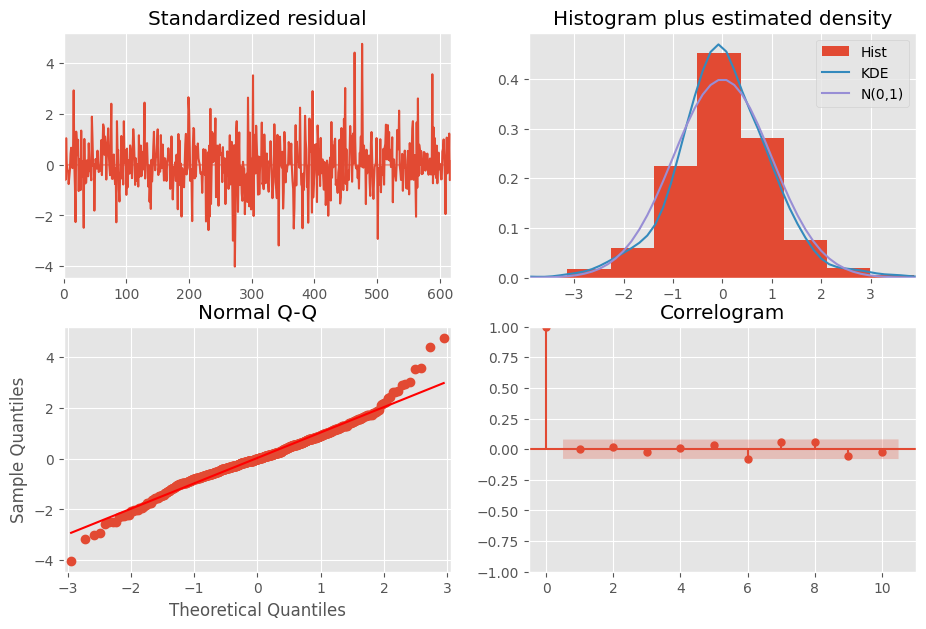

In [22]:
# Autoarima example output
autoarima_SAP = auto_arima(train_dict_arima['SAP_DE'], 
                      start_p=0, start_q=0,  #minimum p and q
                      test='adf',            #use augmented dickey-fuller test to find optimal 'd'
                      max_p=3, max_q=3,      #maximum p and q
                      d=None,                #let model determine 'd'
                      seasonal=False,        #no seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(autoarima_SAP.summary())
autoarima_SAP.plot_diagnostics(figsize=(11,7))
plt.show()

### 1.6. Pre-Processing for LSTM (Splitting Sequences & Generating Train/Test Sets)
<a name="pre-lstm"></a>

In [23]:
# Creating LSTM input and output sequences for training, validation, and testing
X_train_dict, Y_train_dict = {}, {}
X_val_dict, Y_val_dict = {}, {}
X_test_dict, Y_test_dict = {}, {}

def prepare_sequences(X_seq, Y_seq, n_features, input_steps):
    # Ensure concatenation is done similarly to Method 1
    X_reshaped = np.concatenate([X_seq[0], X_seq[1], X_seq[2]])  # Concatenate along feature axis
    X_reshaped = np.reshape(X_reshaped, (int(X_reshaped.shape[0]/(n_features+1)), input_steps, n_features + 1), order='F')
    Y_reshaped = np.array([y[output_steps - 1] for y in Y_seq])
    return X_reshaped, Y_reshaped

# Loop through each ticker in the data dictionary
for ticker, df in data_dict.items():
    if '1d_return' in df.columns and 'Rolling_Mean' in df.columns and 'Rolling_Std' in df.columns:
        # Generate sequences for each feature and the target
        X_seq = split_sequence(df['1d_return'].values, input_steps, output_steps)
        X1_seq = split_sequence(df['Rolling_Mean'].values, input_steps, output_steps)
        X2_seq = split_sequence(df['Rolling_Std'].values, input_steps, output_steps)
        
        # Concatenate and reshape sequences
        X_ft, Y = prepare_sequences([X_seq[0], X1_seq[0], X2_seq[0]], X_seq[1], n_features, input_steps)

        # Split into train, validation, and test sets
        X_temp, X_test, Y_temp, Y_test = train_test_split(X_ft, Y, test_size=0.2, shuffle=False)
        X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, shuffle=False)
        
        # Store in dictionaries
        X_train_dict[ticker] = X_train
        Y_train_dict[ticker] = Y_train
        X_val_dict[ticker] = X_val
        Y_val_dict[ticker] = Y_val
        X_test_dict[ticker] = X_test
        Y_test_dict[ticker] = Y_test

## 2. LSTM & ARIMA
<a name="arima-lstm"></a>

### 2.1 LSTM Predictions
<a name="lstm"></a>

In [24]:
#hyperparameter for lstm
epochs = 20
max_trials = 20
patience = 10
verbose = 1

In [25]:
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [26]:
# Computing LSTM results
results_lstm = {}  # Ensure this is initialized outside the loop

for company_name, X_train in X_train_dict.items():
    Y_train = Y_train_dict[company_name]
    X_val = X_val_dict[company_name]
    Y_val = Y_val_dict[company_name]
    input_steps = X_train.shape[1]
    n_features = X_train.shape[2]

    # Perform hyperparameter tuning to find the best model parameters
    print(f"Hyperparameter tuning for {company_name}...")
    best_hyperparameters = lstm_hp_random_search(X_train, Y_train, X_val, Y_val, input_steps, n_features - 1, company_name, epochs, max_trials=20, patience=10)  # Ensure n_features is correctly adjusted if needed

    # Train the final model with the best hyperparameters
    print(f"Final training and prediction for {company_name}...")
    model, history = train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features - 1, epochs, patience, verbose)
    model_summary = get_model_summary(model)

    # Predict and flatten the output
    yhat = model.predict(X_test_dict[company_name])
    yhat_flat = [item for sublist in yhat.tolist() for item in sublist]

    # Calculate performance metrics
    mse = mean_squared_error(Y_test_dict[company_name], yhat_flat)
    mae = mean_absolute_error(Y_test_dict[company_name], yhat_flat)
    rmse = math.sqrt(mse)

    # Store predictions, metrics, and training history
    results_lstm[company_name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'Predictions': yhat_flat,
        'History': history.history,  # Store the training and validation loss over epochs
        'Summary': model_summary
    }

    print(f'{company_name} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')

Trial 20 Complete [00h 00m 18s]
val_loss: 0.00040190230356529355

Best val_loss So Far: 0.00039843079866841435
Total elapsed time: 00h 06m 19s
Final training and prediction for VOW3_DE...
Epoch 1/20
15/15 [==============================] - 5s 66ms/step - loss: 5.5817e-04 - val_loss: 4.1322e-04
Epoch 2/20
15/15 [==============================] - 0s 5ms/step - loss: 5.6093e-04 - val_loss: 4.0834e-04
Epoch 3/20
15/15 [==============================] - 0s 4ms/step - loss: 5.5374e-04 - val_loss: 4.0658e-04
Epoch 4/20
15/15 [==============================] - 0s 4ms/step - loss: 5.5108e-04 - val_loss: 4.0669e-04
Epoch 5/20
15/15 [==============================] - 0s 4ms/step - loss: 5.5359e-04 - val_loss: 4.0643e-04
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 5.4980e-04 - val_loss: 4.0623e-04
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 5.5044e-04 - val_loss: 4.0713e-04
Epoch 8/20
15/15 [==============================] - 0s 4ms/step - los

### 2.2 ARIMA Predictions
<a name="arima"></a>

In [27]:
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [29]:
warnings.filterwarnings("ignore")

results_arima = {}
for company, train_data in train_dict_arima.items():
    test_data = test_dict_arima[company]
    order = autoarima_dict[company].order
    output_steps = output_steps  # Adjust this if necessary
    
    mse, mae, rmse, predicted_flat, summary = arima_model(train_data, test_data, order, output_steps)
    results_arima[company] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'Predictions': predicted_flat,
        'Summary': summary
    }
    print(f'{company} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')


ABI_BR - MSE: 1.243439e-04, MAE: 8.267077e-03, RMSE: 1.115096e-02
ADS_DE - MSE: 3.812698e-04, MAE: 1.425758e-02, RMSE: 1.952613e-02
ADYEN_AS - MSE: 2.431754e-03, MAE: 2.245580e-02, RMSE: 4.931282e-02
AD_AS - MSE: 1.336739e-04, MAE: 7.450077e-03, RMSE: 1.156174e-02
AIR_PA - MSE: 1.325042e-04, MAE: 8.701358e-03, RMSE: 1.151105e-02
AI_PA - MSE: 1.070361e-04, MAE: 7.487486e-03, RMSE: 1.034583e-02
ALV_DE - MSE: 8.467615e-05, MAE: 6.698135e-03, RMSE: 9.201965e-03
ASML_AS - MSE: 2.608911e-04, MAE: 1.215579e-02, RMSE: 1.615212e-02
BAS_DE - MSE: 2.296515e-04, MAE: 1.127100e-02, RMSE: 1.515426e-02
BAYN_DE - MSE: 3.949289e-04, MAE: 1.125590e-02, RMSE: 1.987282e-02
BBVA_MC - MSE: 1.508055e-04, MAE: 9.465885e-03, RMSE: 1.228029e-02
BMW_DE - MSE: 1.884194e-04, MAE: 1.034086e-02, RMSE: 1.372660e-02
BNP_PA - MSE: 1.574980e-04, MAE: 9.350997e-03, RMSE: 1.254982e-02
BN_PA - MSE: 7.590582e-05, MAE: 6.732535e-03, RMSE: 8.712394e-03
CRH - MSE: 2.449581e-04, MAE: 1.188175e-02, RMSE: 1.565114e-02
CS_PA - MSE

### 2.3 Comparison of ARIMA & LSTM Predictions
<a name="comp-arima-lstm"></a>

In [30]:
# Placeholder for storing all companies' comparison results
results_comp = {}

for company in data_dict.keys():
    min_comp = min(len(results_lstm[company]['Predictions']), len(results_arima[company]['Predictions']))
    
    pred_lstm = pd.Series(results_lstm[company]['Predictions'][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)
    pred_arima = pd.Series(results_arima[company]['Predictions'][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)
    
    actual = pd.Series(Y_test_dict[company][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)
    
    predictions = pd.concat([actual, pred_lstm, pred_arima], axis=1, keys=['actual', 'pred_lstm', 'pred_arima'])
    
    results_comp[company] = predictions


In [ ]:
# Specify the new working directory
new_directory = "/Users/cemakkus/PycharmProjects/Master"

# Change the current working directory
os.chdir(new_directory)

# Verify the change
print("New Current Working Directory:", os.getcwd())

In [ ]:
# Directory where the CSV files are saved
results_dir = 'results'

# Dictionary to hold the loaded DataFrames
results_comp = {}

# Load each CSV file into the dictionary
for company in data_dict.keys():
    file_path = f'{results_dir}/predictions_{company}.csv'
    results_comp[company] = pd.read_csv(file_path, index_col=0)

In [40]:
# Placeholder to store MSE results for each company and model
mse_results = {}

# Placeholder to count instances where each model has a lower MSE
lstm_better_count = 0
arima_better_count = 0

# Lists to collect MSEs for averaging
mse_lstm_list = []
mse_arima_list = []

for company, df in results_comp.items():
    # Initialize lists to store squared errors
    lstm_squared_errors = []
    arima_squared_errors = []
    
    # Iterate over each prediction step
    for index, row in df.iterrows():
        actual = row['actual']
        pred_lstm = row['pred_lstm']
        pred_arima = row['pred_arima']
        
        # Calculate squared errors
        lstm_squared_error = (actual - pred_lstm) ** 2
        arima_squared_error = (actual - pred_arima) ** 2
        
        # Append to lists
        lstm_squared_errors.append(lstm_squared_error)
        arima_squared_errors.append(arima_squared_error)
    
    # Calculate MSE for LSTM predictions
    mse_lstm = np.mean(lstm_squared_errors)
    mse_lstm_list.append(mse_lstm)
    
    # Calculate MSE for ARIMA predictions
    mse_arima = np.mean(arima_squared_errors)
    mse_arima_list.append(mse_arima)
    
    # Store the MSE results in the dictionary
    mse_results[company] = {'MSE_LSTM': mse_lstm, 'MSE_ARIMA': mse_arima}
    
    # Count which model had a lower MSE for this company
    if mse_lstm < mse_arima:
        lstm_better_count += 1
    else:
        arima_better_count += 1

# Calculate the average MSE for each model
average_mse_lstm = np.mean(mse_lstm_list)
average_mse_arima = np.mean(mse_arima_list)

# Print the results
print(f"Average MSE for LSTM: {average_mse_lstm}")
print(f"Average MSE for ARIMA: {average_mse_arima}")
print(f"Number of companies where LSTM had a lower MSE: {lstm_better_count}")
print(f"Number of companies where ARIMA had a lower MSE: {arima_better_count}")

# Print individual MSEs for companies
for company, mse in mse_results.items():
    print(f"Company: {company}, MSE_LSTM: {mse['MSE_LSTM']}, MSE_ARIMA: {mse['MSE_ARIMA']}")


Average MSE for LSTM: 0.0002492652659456213
Average MSE for ARIMA: 0.00024379110890358595
Number of companies where LSTM had a lower MSE: 14
Number of companies where ARIMA had a lower MSE: 34
Company: ABI_BR, MSE_LSTM: 0.0001272194852966318, MSE_ARIMA: 0.00012556334696575873
Company: ADS_DE, MSE_LSTM: 0.00034404290222523573, MSE_ARIMA: 0.0003470174161485976
Company: ADYEN_AS, MSE_LSTM: 0.0025485560743302117, MSE_ARIMA: 0.002494178719687161
Company: AD_AS, MSE_LSTM: 0.0001370665208038327, MSE_ARIMA: 0.00013594315002104387
Company: AIR_PA, MSE_LSTM: 0.00013730438366758838, MSE_ARIMA: 0.000134181814175844
Company: AI_PA, MSE_LSTM: 0.00010999163601464599, MSE_ARIMA: 0.00010915731435469002
Company: ALV_DE, MSE_LSTM: 8.674734790432411e-05, MSE_ARIMA: 8.653963047316855e-05
Company: ASML_AS, MSE_LSTM: 0.00026736619958469935, MSE_ARIMA: 0.0002657792276532721
Company: BAS_DE, MSE_LSTM: 0.00023193785700661673, MSE_ARIMA: 0.00023124087456203907
Company: BAYN_DE, MSE_LSTM: 0.00042185153457916343, 

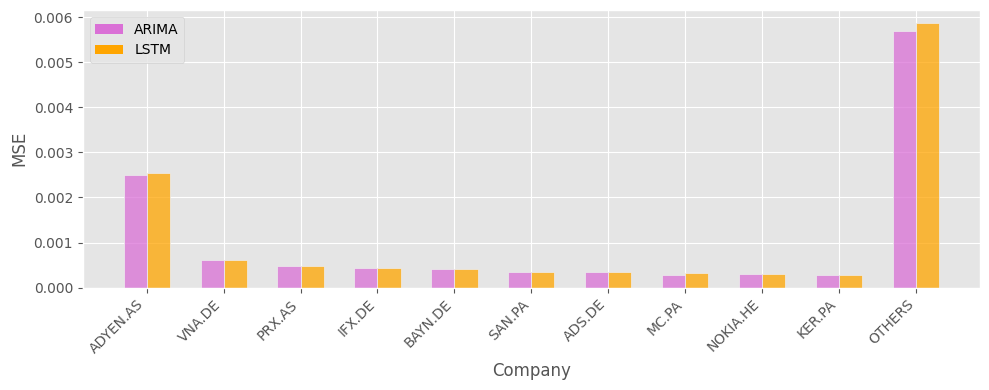

In [42]:
# Create a DataFrame for visualization
mse_df = pd.DataFrame(mse_results).T

# Format company names
mse_df.index = mse_df.index.str.replace('_', '.').str.lower()

# Calculate the total MSE for each model
total_mse_lstm = np.sum(mse_lstm_list)
total_mse_arima = np.sum(mse_arima_list)

# Calculate the contribution to total MSE
mse_df['Contribution_LSTM'] = mse_df['MSE_LSTM'] / total_mse_lstm
mse_df['Contribution_ARIMA'] = mse_df['MSE_ARIMA'] / total_mse_arima

# Sort the DataFrame by contribution
mse_df = mse_df.sort_values(by='Contribution_LSTM', ascending=False)

# Truncate the DataFrame to show only the top 10 companies and summarize the rest
top_10 = mse_df.head(10)
rest = mse_df.iloc[10:].sum().to_frame().T
rest.index = ['others']

# Combine the top 10 with the rest
mse_df_truncated = pd.concat([top_10, rest])

# Melt the DataFrame for seaborn, only including MSE_ARIMA and MSE_LSTM
mse_df_melted = mse_df_truncated[['MSE_ARIMA', 'MSE_LSTM']].reset_index().melt(id_vars='index', var_name='Model', value_name='MSE')

# Rename the values in the 'Model' column
mse_df_melted['Model'] = mse_df_melted['Model'].replace({'MSE_ARIMA': 'ARIMA', 'MSE_LSTM': 'LSTM'})

# Ensure that 'index' is treated as a categorical variable and convert to uppercase
mse_df_melted['index'] = pd.Categorical(mse_df_melted['index'].str.upper(), categories=mse_df_truncated.index.str.upper(), ordered=True)

# Plotting the histogram with seaborn
plt.figure(figsize=(10, 4))
sns.histplot(data=mse_df_melted, x='index', hue='Model', weights='MSE', multiple='dodge', shrink=0.6, palette=['orchid', 'orange'])
plt.xlabel('Company')
plt.ylabel('MSE')
plt.xticks(rotation=45, ha='right')

# Manually create custom legend
custom_handles = [Patch(facecolor='orchid', label='ARIMA'), Patch(facecolor='orange', label='LSTM')]
plt.legend(handles=custom_handles, title='')

plt.tight_layout()
plt.show()

In [55]:
# Calculate classification metrics
def calculate_metrics_comp(results_comp):
    metrics_comp = {}
    
    for company in results_comp.keys():
        # Initialize counters
        metrics = {'tp_arima': 0, 'fp_arima': 0, 'tn_arima': 0, 'fn_arima': 0,
                   'tp_lstm': 0, 'fp_lstm': 0, 'tn_lstm': 0, 'fn_lstm': 0}
        
        # Derive sign columns
        actual_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['actual']]
        pred_arima_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_arima']]
        pred_lstm_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_lstm']]
        
        # Calculate confusion matrix for ARIMA and LSTM
        for actual, pred_arima, pred_lstm in zip(actual_sign, pred_arima_sign, pred_lstm_sign):
            if actual == 'Pos' and pred_arima == 'Pos':
                metrics['tp_arima'] += 1
            elif actual == 'Pos' and pred_arima == 'Neg':
                metrics['fn_arima'] += 1
            elif actual == 'Neg' and pred_arima == 'Neg':
                metrics['tn_arima'] += 1
            else:
                metrics['fp_arima'] += 1
                
            if actual == 'Pos' and pred_lstm == 'Pos':
                metrics['tp_lstm'] += 1
            elif actual == 'Pos' and pred_lstm == 'Neg':
                metrics['fn_lstm'] += 1
            elif actual == 'Neg' and pred_lstm == 'Neg':
                metrics['tn_lstm'] += 1
            else:
                metrics['fp_lstm'] += 1
        
        # Function to calculate precision, recall, F1 score, and accuracy
        def calculate_metrics(tp, fp, fn, tn):
            precision = round(tp / (tp + fp) if (tp + fp) else 0, 4)
            recall = round(tp / (tp + fn) if (tp + fn) else 0, 4)
            f1 = round(2 * (precision * recall) / (precision + recall) if (precision + recall) else 0, 4)
            accuracy = round((tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) else 0, 4)
            return precision, recall, f1, accuracy
        
        # Calculate metrics for ARIMA
        precision_arima, recall_arima, f1_arima, accuracy_arima = calculate_metrics(metrics['tp_arima'], metrics['fp_arima'], metrics['fn_arima'], metrics['tn_arima'])
        
        # Calculate metrics for LSTM
        precision_lstm, recall_lstm, f1_lstm, accuracy_lstm = calculate_metrics(metrics['tp_lstm'], metrics['fp_lstm'], metrics['fn_lstm'], metrics['tn_lstm'])
        
        # Store metrics
        metrics_comp[company] = {
            'ARIMA': {'TP': metrics['tp_arima'], 'FP': metrics['fp_arima'], 'TN': metrics['tn_arima'], 'FN': metrics['fn_arima'],
                      'Precision': precision_arima, 'Recall': recall_arima, 'F1': f1_arima, 'Accuracy': accuracy_arima},
            'LSTM': {'TP': metrics['tp_lstm'], 'FP': metrics['fp_lstm'], 'TN': metrics['tn_lstm'], 'FN': metrics['fn_lstm'],
                     'Precision': precision_lstm, 'Recall': recall_lstm, 'F1': f1_lstm, 'Accuracy': accuracy_lstm}
        }
        
    return metrics_comp

In [56]:
# Print all metrics
metrics_comp = calculate_metrics_comp(results_comp)

for company, metrics in metrics_comp.items():
    print(f"Metrics for {company} - ARIMA:")
    print(metrics['ARIMA'])
    print(f"Metrics for {company} - LSTM:")
    print(metrics['LSTM'])
    print("\n") 

Metrics for ABI_BR - ARIMA:
{'TP': 36, 'FP': 30, 'TN': 38, 'FN': 49, 'Precision': 0.5455, 'Recall': 0.4235, 'F1': 0.4768, 'Accuracy': 0.4837}
Metrics for ABI_BR - LSTM:
{'TP': 80, 'FP': 60, 'TN': 8, 'FN': 5, 'Precision': 0.5714, 'Recall': 0.9412, 'F1': 0.7111, 'Accuracy': 0.5752}


Metrics for ADS_DE - ARIMA:
{'TP': 0, 'FP': 0, 'TN': 77, 'FN': 74, 'Precision': 0, 'Recall': 0.0, 'F1': 0, 'Accuracy': 0.5099}
Metrics for ADS_DE - LSTM:
{'TP': 34, 'FP': 38, 'TN': 39, 'FN': 40, 'Precision': 0.4722, 'Recall': 0.4595, 'F1': 0.4658, 'Accuracy': 0.4834}


Metrics for ADYEN_AS - ARIMA:
{'TP': 23, 'FP': 36, 'TN': 42, 'FN': 52, 'Precision': 0.3898, 'Recall': 0.3067, 'F1': 0.3433, 'Accuracy': 0.4248}
Metrics for ADYEN_AS - LSTM:
{'TP': 0, 'FP': 2, 'TN': 76, 'FN': 75, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0, 'Accuracy': 0.4967}


Metrics for AD_AS - ARIMA:
{'TP': 64, 'FP': 56, 'TN': 15, 'FN': 18, 'Precision': 0.5333, 'Recall': 0.7805, 'F1': 0.6336, 'Accuracy': 0.5163}
Metrics for AD_AS - LSTM:
{'TP

In [57]:
# Calculate average accuracies for each model
def calculate_average_accuracies(metrics_comp):
    total_accuracies = {
        'ARIMA': 0,
        'LSTM': 0,
    }
    num_companies = len(metrics_comp)

    for company, metrics in metrics_comp.items():
        total_accuracies['ARIMA'] += metrics['ARIMA']['Accuracy']
        total_accuracies['LSTM'] += metrics['LSTM']['Accuracy']

    average_accuracies = {model: round(total / num_companies, 4) for model, total in total_accuracies.items()}
    return average_accuracies

metrics_comp = calculate_metrics_comp(results_comp)
average_accuracies = calculate_average_accuracies(metrics_comp)

print("Average Accuracies:")
for model, accuracy in average_accuracies.items():
    print(f"{model}: {accuracy}")

Average Accuracies:
ARIMA: 0.519
LSTM: 0.5063


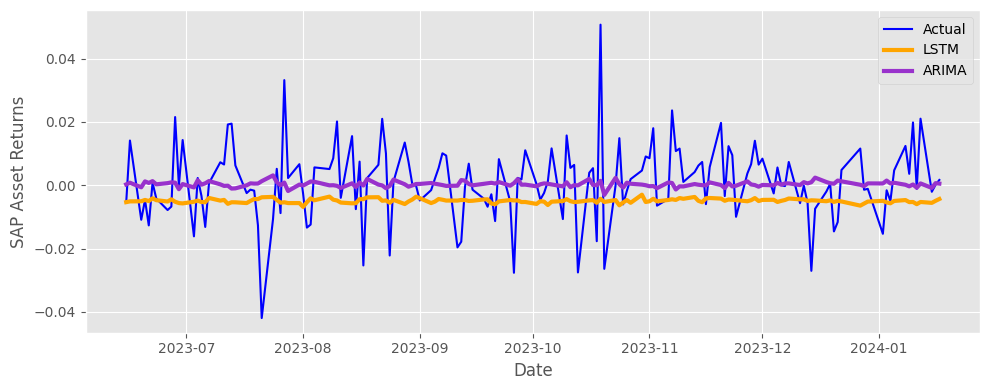

In [47]:
# Time series plot of SAP predictions from LSTM and ARIMA 
dates = results_comp['SAP_DE'].index  

plt.figure(figsize=(10, 4))  
plt.plot(dates, results_comp['SAP_DE']['actual'], color='blue', label='Actual')
plt.plot(dates, results_comp['SAP_DE']['pred_lstm'], color='orange', label='LSTM', linewidth=3)
plt.plot(dates, results_comp['SAP_DE']['pred_arima'], color='darkorchid', label='ARIMA', linewidth=3)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  

plt.xlabel('Date')
plt.ylabel('SAP Asset Returns')
plt.legend()
plt.tight_layout()
plt.show()

## 3. LSTM_NAD Prediction
<a name="lstmnad"></a>

### 3.1. Pre-Processing for LSTM_NAD
<a name="pre-lstmnad"></a>

In [38]:
# Updated hyperparameter for feature engineering
n_features = 4
window = 10

In [125]:
# Initialize dictionaries to store the LSTM input and output sequences for training, validation, and testing
X_train_dict, Y_train_dict = {}, {}
X_val_dict, Y_val_dict = {}, {}
X_test_dict, Y_test_dict = {}, {}

def prepare_sequences(X_seqs, Y_seq, input_steps):
    # Concatenate along feature axis for all provided X sequences
    X_reshaped = np.concatenate(X_seqs, axis=1)
    X_reshaped = np.reshape(X_reshaped, (-1, input_steps, len(X_seqs)))
    Y_reshaped = np.array([y[output_steps - 1] for y in Y_seq])
    return X_reshaped, Y_reshaped

# Loop through each ticker in the data dictionary
for ticker, df in data_dict.items():
    required_features = ['1d_return', 'sentiment', 'volume', 'esg_score', 'general_risk_score']
    if all(feature in df.columns for feature in required_features):
        # Generate sequences for each feature and the target
        X_seq = split_sequence(df['1d_return'].values, input_steps, output_steps)
        X_seqs = [split_sequence(df[feature].values, input_steps, output_steps)[0] for feature in required_features[1:]]
        
        # Concatenate and reshape sequences
        X_ft, Y = prepare_sequences(X_seqs, X_seq[1], input_steps)

        # Split into train, validation, and test sets
        X_temp, X_test, Y_temp, Y_test = train_test_split(X_ft, Y, test_size=0.2, shuffle=False)
        X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, shuffle=False)
        
        # Store in dictionaries
        X_train_dict[ticker] = X_train
        Y_train_dict[ticker] = Y_train
        X_val_dict[ticker] = X_val
        Y_val_dict[ticker] = Y_val
        X_test_dict[ticker] = X_test
        Y_test_dict[ticker] = Y_test

### 3.2. LSTM_NAD Predictions
<a name="pred-lstmnad"></a>

In [51]:
# Hyperparameter for lstm
epochs = 20
max_trials = 20
patience = 10
verbose = 1

In [52]:
# Setting seed again
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
results_lstm_nad = {}  # Initialized with the new name

for company_name, X_train in X_train_dict.items():#reversed_X_train_dict.items(): #X_train_dict.items():
    X_train = X_train_dict[company_name]
    Y_train = Y_train_dict[company_name]
    X_val = X_val_dict[company_name]
    Y_val = Y_val_dict[company_name]
    input_steps = X_train.shape[1]
    # Adjust n_features based on new data structure
    n_features = X_train.shape[2] - 1

    print(f"Hyperparameter tuning for {company_name}...")
    best_hyperparameters = lstm_hp_random_search(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name, epochs, max_trials=20, patience=10)


    print(f"Final training and prediction for {company_name}...")
    model, history = train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features, epochs, patience, verbose)
    model_summary = get_model_summary(model)

    yhat = model.predict(X_test_dict[company_name])
    yhat_flat = [item for sublist in yhat.tolist() for item in sublist]

    mse = mean_squared_error(Y_test_dict[company_name], yhat_flat)
    mae = mean_absolute_error(Y_test_dict[company_name], yhat_flat)
    rmse = math.sqrt(mse)

    results_lstm_nad[company_name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'Predictions': yhat_flat,
        'History': history.history,  # Store the training and validation loss over epochs
        'Summary': model_summary
    }

    print(f'{company_name} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')

### 3.3. Comparison of ARIMA, LSTM & LSTM_NAD Predictions
<a name="comp-lstmnad"></a>

In [ ]:
# Placeholder for storing all companies' comparison results
results_comp = {}

for company in data_dict.keys():
    # Determine the minimum length for comparison across LSTM and ARIMA predictions
    min_comp = min(len(results_lstm[company]['Predictions']), len(results_arima[company]['Predictions']))

    # Extract the relevant portions of predictions
    pred_lstm = pd.Series(results_lstm[company]['Predictions'][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)
    pred_arima = pd.Series(results_arima[company]['Predictions'][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)
    pred_lstm_nad = pd.Series(results_lstm_nad[company]['Predictions'][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)

    # Assuming Y_test_dict is similarly structured to data_dict and results dicts
    actual = pd.Series(Y_test_dict[company][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)

    # Concatenate actual values and predictions for LSTM and ARIMA into one DataFrame
    predictions = pd.concat([actual, pred_lstm, pred_arima, pred_lstm_nad], axis=1, keys=['actual', 'pred_lstm', 'pred_arima', 'pred_lstm_nad'])

    # Store the combined DataFrame in the results_comp dictionary
    results_comp[company] = predictions

In [48]:
# Directory where the CSV files are saved
results_dir = 'results'

# Dictionary to hold the loaded DataFrames
results_comp = {}

# Load each CSV file into the dictionary
for company in data_dict.keys():
    file_path = f'{results_dir}/predictions_{company}.csv'
    results_comp[company] = pd.read_csv(file_path, index_col=0)

# Now results_comp contains DataFrames loaded from the CSV files, keyed by the NHE keys


In [50]:
# Placeholder to store MSE results for each company and model
mse_results = {}

# Placeholder to count instances where each model has a lower MSE
lstm_better_count = 0
arima_better_count = 0
lstm_nad_better_count = 0

# Lists to collect MSEs for averaging
mse_lstm_list = []
mse_arima_list = []
mse_lstm_nad_list = []

for company, df in results_comp.items():
    # Initialize lists to store squared errors
    lstm_squared_errors = []
    arima_squared_errors = []
    lstm_nad_squared_errors = []
    
    # Iterate over each prediction step
    for index, row in df.iterrows():
        actual = row['actual']
        pred_lstm = row['pred_lstm']
        pred_arima = row['pred_arima']
        pred_lstm_nad = row['pred_lstm_nad']
        
        # Calculate squared errors
        lstm_squared_error = (actual - pred_lstm) ** 2
        arima_squared_error = (actual - pred_arima) ** 2
        lstm_nad_squared_error = (actual - pred_lstm_nad) ** 2
        
        # Append to lists
        lstm_squared_errors.append(lstm_squared_error)
        arima_squared_errors.append(arima_squared_error)
        lstm_nad_squared_errors.append(lstm_nad_squared_error)
    
    # Calculate MSE for LSTM predictions
    mse_lstm = np.mean(lstm_squared_errors)
    mse_lstm_list.append(mse_lstm)
    
    # Calculate MSE for ARIMA predictions
    mse_arima = np.mean(arima_squared_errors)
    mse_arima_list.append(mse_arima)
    
    # Calculate MSE for LSTM NAD predictions
    mse_lstm_nad = np.mean(lstm_nad_squared_errors)
    mse_lstm_nad_list.append(mse_lstm_nad)
    
    # Store the MSE results in the dictionary
    mse_results[company] = {'MSE_LSTM': mse_lstm, 'MSE_ARIMA': mse_arima, 'MSE_LSTM_NAD': mse_lstm_nad}
    
    # Count which model had a lower MSE for this company
    if mse_lstm < mse_arima and mse_lstm < mse_lstm_nad:
        lstm_better_count += 1
    elif mse_arima < mse_lstm and mse_arima < mse_lstm_nad:
        arima_better_count += 1
    else:
        lstm_nad_better_count += 1

# Calculate the average MSE for each model
average_mse_lstm = np.mean(mse_lstm_list)
average_mse_arima = np.mean(mse_arima_list)
average_mse_lstm_nad = np.mean(mse_lstm_nad_list)

# Print the results
print(f"Average MSE for LSTM: {average_mse_lstm}")
print(f"Average MSE for ARIMA: {average_mse_arima}")
print(f"Average MSE for LSTM NAD: {average_mse_lstm_nad}")
print(f"Number of companies where LSTM had a lower MSE: {lstm_better_count}")
print(f"Number of companies where ARIMA had a lower MSE: {arima_better_count}")
print(f"Number of companies where LSTM NAD had a lower MSE: {lstm_nad_better_count}")

# Print individual MSEs for companies
for company, mse in mse_results.items():
    print(f"Company: {company}, MSE_LSTM: {mse['MSE_LSTM']}, MSE_ARIMA: {mse['MSE_ARIMA']}, MSE_LSTM_NAD: {mse['MSE_LSTM_NAD']}")

Average MSE for LSTM: 0.0002456615493834191
Average MSE for ARIMA: 0.0002428704514884077
Average MSE for LSTM NAD: 0.0002766041594885905
Number of companies where LSTM had a lower MSE: 20
Number of companies where ARIMA had a lower MSE: 26
Number of companies where LSTM NAD had a lower MSE: 2
Company: ABI_BR, MSE_LSTM: 0.00012569922230538567, MSE_ARIMA: 0.00012383930282169596, MSE_LSTM_NAD: 0.0001319693911811973
Company: ADS_DE, MSE_LSTM: 0.0003953291698272436, MSE_ARIMA: 0.0003837415862175188, MSE_LSTM_NAD: 0.0004069481482959671
Company: ADYEN_AS, MSE_LSTM: 0.0024329403048016876, MSE_ARIMA: 0.002446963235810673, MSE_LSTM_NAD: 0.002473295408940025
Company: AD_AS, MSE_LSTM: 0.00014459446310038132, MSE_ARIMA: 0.00013453075310230095, MSE_LSTM_NAD: 0.0001366981075482776
Company: AIR_PA, MSE_LSTM: 0.00013218770016337536, MSE_ARIMA: 0.00013335750720949716, MSE_LSTM_NAD: 0.00019173785130805032
Company: AI_PA, MSE_LSTM: 0.00010690824704692204, MSE_ARIMA: 0.00010769604051489333, MSE_LSTM_NAD: 0

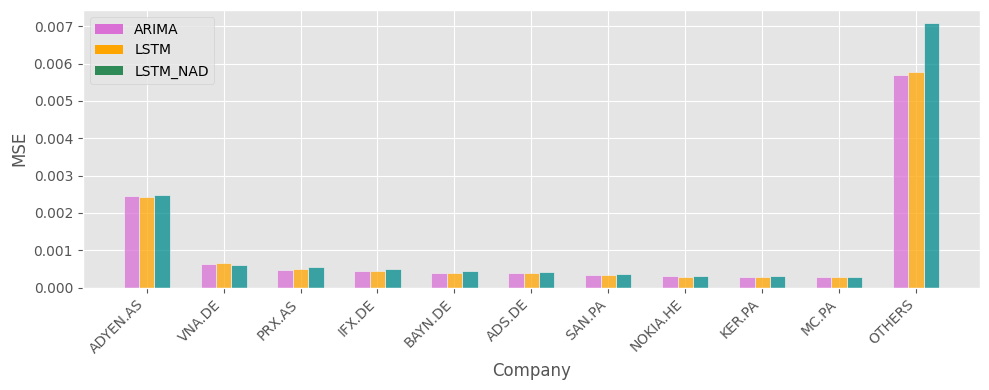

In [52]:
# Create a DataFrame for visualization
mse_df = pd.DataFrame(mse_results).T

# Format company names
mse_df.index = mse_df.index.str.replace('_', '.').str.lower()

# Calculate the total MSE for each model
total_mse_lstm = np.sum(mse_lstm_list)
total_mse_arima = np.sum(mse_arima_list)

# Calculate the contribution to total MSE
mse_df['Contribution_LSTM'] = mse_df['MSE_LSTM'] / total_mse_lstm
mse_df['Contribution_ARIMA'] = mse_df['MSE_ARIMA'] / total_mse_arima

# Sort the DataFrame by contribution
mse_df = mse_df.sort_values(by='Contribution_LSTM', ascending=False)

# Truncate the DataFrame to show only the top 10 companies and summarize the rest
top_10 = mse_df.head(10)
rest = mse_df.iloc[10:].sum().to_frame().T
rest.index = ['others']

# Combine the top 10 with the rest
mse_df_truncated = pd.concat([top_10, rest])

# Melt the DataFrame for seaborn, including MSE_ARIMA, MSE_LSTM, and MSE_LSTM_NAD
mse_df_melted = mse_df_truncated[['MSE_ARIMA', 'MSE_LSTM', 'MSE_LSTM_NAD']].reset_index().melt(id_vars='index', var_name='Model', value_name='MSE')

# Rename the values in the 'Model' column
mse_df_melted['Model'] = mse_df_melted['Model'].replace({'MSE_ARIMA': 'ARIMA', 'MSE_LSTM': 'LSTM', 'MSE_LSTM_NAD': 'LSTM_NAD'})

# Ensure that 'index' is treated as a categorical variable and convert to uppercase
mse_df_melted['index'] = pd.Categorical(mse_df_melted['index'].str.upper(), categories=mse_df_truncated.index.str.upper(), ordered=True)

# Plotting the histogram with seaborn
plt.figure(figsize=(10, 4))
sns.histplot(data=mse_df_melted, x='index', hue='Model', weights='MSE', multiple='dodge', shrink=0.6, palette=['orchid', 'orange', 'darkcyan'])
plt.xlabel('Company')
plt.ylabel('MSE')
plt.xticks(rotation=45, ha='right')

# Manually create custom legend
custom_handles = [Patch(facecolor='orchid', label='ARIMA'), Patch(facecolor='orange', label='LSTM'), Patch(facecolor='seagreen', label='LSTM_NAD')]
plt.legend(handles=custom_handles, title='')

plt.tight_layout()
plt.show()

In [53]:
# Calculate metrics for model companies
def calculate_metrics_comp(results_comp):
    metrics_comp = {}

    for company in results_comp.keys():
        # Initialize counters
        metrics = {'tp_arima': 0, 'fp_arima': 0, 'tn_arima': 0, 'fn_arima': 0,
                   'tp_lstm': 0, 'fp_lstm': 0, 'tn_lstm': 0, 'fn_lstm': 0,
                   'tp_lstm_nad': 0, 'fp_lstm_nad': 0, 'tn_lstm_nad': 0, 'fn_lstm_nad': 0}

        # Derive sign columns
        actual_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['actual']]
        pred_arima_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_arima']]
        pred_lstm_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_lstm']]
        pred_lstm_nad_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_lstm_nad']]

        # Calculate confusion matrix for ARIMA, LSTM, and LSTM_NAD
        for actual, pred_arima, pred_lstm, pred_lstm_nad in zip(actual_sign, pred_arima_sign, pred_lstm_sign, pred_lstm_nad_sign):
            # ARIMA
            if actual == 'Pos' and pred_arima == 'Pos':
                metrics['tp_arima'] += 1
            elif actual == 'Pos' and pred_arima == 'Neg':
                metrics['fn_arima'] += 1
            elif actual == 'Neg' and pred_arima == 'Neg':
                metrics['tn_arima'] += 1
            else:
                metrics['fp_arima'] += 1

            # LSTM
            if actual == 'Pos' and pred_lstm == 'Pos':
                metrics['tp_lstm'] += 1
            elif actual == 'Pos' and pred_lstm == 'Neg':
                metrics['fn_lstm'] += 1
            elif actual == 'Neg' and pred_lstm == 'Neg':
                metrics['tn_lstm'] += 1
            else:
                metrics['fp_lstm'] += 1

            # LSTM_NAD
            if actual == 'Pos' and pred_lstm_nad == 'Pos':
                metrics['tp_lstm_nad'] += 1
            elif actual == 'Pos' and pred_lstm_nad == 'Neg':
                metrics['fn_lstm_nad'] += 1
            elif actual == 'Neg' and pred_lstm_nad == 'Neg':
                metrics['tn_lstm_nad'] += 1
            else:
                metrics['fp_lstm_nad'] += 1

        # Function to calculate precision, recall, F1 score, and accuracy
        def calculate_metrics(tp, fp, fn, tn):
            precision = round(tp / (tp + fp) if (tp + fp) else 0, 4)
            recall = round(tp / (tp + fn) if (tp + fn) else 0, 4)
            f1 = round(2 * (precision * recall) / (precision + recall) if (precision + recall) else 0, 4)
            accuracy = round((tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) else 0, 4)
            return precision, recall, f1, accuracy

        # Calculate metrics for ARIMA, LSTM, and LSTM_NAD
        precision_arima, recall_arima, f1_arima, accuracy_arima = calculate_metrics(metrics['tp_arima'], metrics['fp_arima'], metrics['fn_arima'], metrics['tn_arima'])
        precision_lstm, recall_lstm, f1_lstm, accuracy_lstm = calculate_metrics(metrics['tp_lstm'], metrics['fp_lstm'], metrics['fn_lstm'], metrics['tn_lstm'])
        precision_lstm_nad, recall_lstm_nad, f1_lstm_nad, accuracy_lstm_nad = calculate_metrics(metrics['tp_lstm_nad'], metrics['fp_lstm_nad'], metrics['fn_lstm_nad'], metrics['tn_lstm_nad'])

        # Store metrics
        metrics_comp[company] = {
            'ARIMA': {'TP': metrics['tp_arima'], 'FP': metrics['fp_arima'], 'TN': metrics['tn_arima'], 'FN': metrics['fn_arima'],
                      'Precision': precision_arima, 'Recall': recall_arima, 'F1': f1_arima, 'Accuracy': accuracy_arima},
            'LSTM': {'TP': metrics['tp_lstm'], 'FP': metrics['fp_lstm'], 'TN': metrics['tn_lstm'], 'FN': metrics['fn_lstm'],
                     'Precision': precision_lstm, 'Recall': recall_lstm, 'F1': f1_lstm, 'Accuracy': accuracy_lstm},
            'LSTM_NAD': {'TP': metrics['tp_lstm_nad'], 'FP': metrics['fp_lstm_nad'], 'TN': metrics['tn_lstm_nad'], 'FN': metrics['fn_lstm_nad'],
                         'Precision': precision_lstm_nad, 'Recall': recall_lstm_nad, 'F1': f1_lstm_nad, 'Accuracy': accuracy_lstm_nad}
        }

    return metrics_comp

In [54]:
metrics_comp = calculate_metrics_comp(results_comp)

# Loop over all companies in metrics_comp to print their metrics
for company, metrics in metrics_comp.items():
    print(f"Metrics for {company} - ARIMA:")
    print(metrics['ARIMA'])
    print(f"Metrics for {company} - LSTM:")
    print(metrics['LSTM'])
    print(f"Metrics for {company} - LSTM_NAD:")
    print(metrics['LSTM_NAD'])
    print("\n")  # Adds a newline for better readability between companies


Metrics for ABI_BR - ARIMA:
{'TP': 37, 'FP': 31, 'TN': 38, 'FN': 50, 'Precision': 0.5441, 'Recall': 0.4253, 'F1': 0.4774, 'Accuracy': 0.4808}
Metrics for ABI_BR - LSTM:
{'TP': 2, 'FP': 2, 'TN': 67, 'FN': 85, 'Precision': 0.5, 'Recall': 0.023, 'F1': 0.044, 'Accuracy': 0.4423}
Metrics for ABI_BR - LSTM_NAD:
{'TP': 9, 'FP': 10, 'TN': 59, 'FN': 78, 'Precision': 0.4737, 'Recall': 0.1034, 'F1': 0.1697, 'Accuracy': 0.4359}


Metrics for ADS_DE - ARIMA:
{'TP': 0, 'FP': 0, 'TN': 77, 'FN': 77, 'Precision': 0, 'Recall': 0.0, 'F1': 0, 'Accuracy': 0.5}
Metrics for ADS_DE - LSTM:
{'TP': 0, 'FP': 0, 'TN': 77, 'FN': 77, 'Precision': 0, 'Recall': 0.0, 'F1': 0, 'Accuracy': 0.5}
Metrics for ADS_DE - LSTM_NAD:
{'TP': 4, 'FP': 4, 'TN': 73, 'FN': 73, 'Precision': 0.5, 'Recall': 0.0519, 'F1': 0.094, 'Accuracy': 0.5}


Metrics for ADYEN_AS - ARIMA:
{'TP': 25, 'FP': 37, 'TN': 42, 'FN': 52, 'Precision': 0.4032, 'Recall': 0.3247, 'F1': 0.3597, 'Accuracy': 0.4295}
Metrics for ADYEN_AS - LSTM:
{'TP': 6, 'FP': 6, '

In [55]:
def calculate_average_accuracies(metrics_comp):
    total_accuracies = {
        'ARIMA': 0,
        'LSTM': 0,
        'LSTM_NAD': 0,
    }
    num_companies = len(metrics_comp)

    for company, metrics in metrics_comp.items():
        total_accuracies['ARIMA'] += metrics['ARIMA']['Accuracy']
        total_accuracies['LSTM'] += metrics['LSTM']['Accuracy']
        total_accuracies['LSTM_NAD'] += metrics['LSTM_NAD']['Accuracy']

    average_accuracies = {model: round(total / num_companies, 4) for model, total in total_accuracies.items()}
    return average_accuracies

metrics_comp = calculate_metrics_comp(results_comp)
average_accuracies = calculate_average_accuracies(metrics_comp)

# Print average accuracies for each model
print("Average Accuracies:")
for model, accuracy in average_accuracies.items():
    print(f"{model}: {accuracy}")


Average Accuracies:
ARIMA: 0.5201
LSTM: 0.5078
LSTM_NAD: 0.495


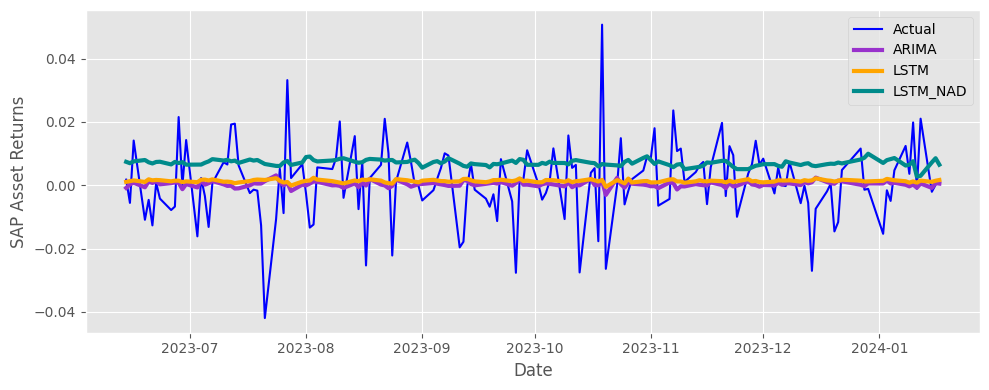

In [57]:
# Ensure the index is in DateTime format
if not isinstance(results_comp['SAP_DE'].index, pd.DatetimeIndex):
    results_comp['SAP_DE'].index = pd.to_datetime(results_comp['SAP_DE'].index)

dates = results_comp['SAP_DE'].index  # Extract the dates corresponding to your data

# Plot - SAP asset return predictions
plt.figure(figsize=(10, 4))  # Optional: Adjust figure size as needed
plt.plot(dates, results_comp['SAP_DE']['actual'], color='blue', label='Actual')
plt.plot(dates, results_comp['SAP_DE']['pred_arima'], color='darkorchid', label='ARIMA', linewidth=3)
plt.plot(dates, results_comp['SAP_DE']['pred_lstm'], color='orange', label='LSTM', linewidth=3)
plt.plot(dates, results_comp['SAP_DE']['pred_lstm_nad'], color='darkcyan', label='LSTM_NAD', linewidth=3)

# Set major ticks format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Month

plt.xlabel('Date')
plt.ylabel('SAP Asset Returns')
plt.legend()
plt.tight_layout()
plt.show()

## 4. LSTM_NHE
<a name="lstmnhe"></a>

### 4.1 Data Preparation for Fine-Tuning
<a name="pre-lstmnhe"></a>

In [95]:
# # Initialize an empty dictionary to store the loaded DataFrames
# headlines_dict = {}

# # Define the directory where the CSV files are saved
# directory = '/Users/cemakkus/PycharmProjects/Master/data/'

# # Iterate through each file in the directory
# for filename in os.listdir(directory):
#     if filename.startswith('headlines_') and filename.endswith('.csv'):
#         # Extract the ticker from the filename
#         ticker = filename.replace('headlines_', '').replace('.csv', '')
        
#         # Define the full file path
#         file_path = os.path.join(directory, filename)
        
#         # Read the CSV file into a DataFrame and exclude the first column
#         df = pd.read_csv(file_path).iloc[:, 1:]
#         headlines_dict[ticker] = df  # Keep all rows as we're not excluding based on output_steps
        
#         print(f'DataFrame for {ticker} loaded from {file_path}')

# # At this point, headlines_dict contains all DataFrames, keyed and sorted by ticker, without the first column in each DataFrame
# headlines_dict = {k: headlines_dict[k] for k in sorted(headlines_dict)}


DataFrame for BAS_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/headlines_BAS_DE.csv
DataFrame for AIR_PA loaded from /Users/cemakkus/PycharmProjects/Master/data/headlines_AIR_PA.csv
DataFrame for adapted_SIE_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/headlines_adapted_SIE_DE.csv
DataFrame for SAP_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/headlines_SAP_DE.csv
DataFrame for DTE_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/headlines_DTE_DE.csv
DataFrame for adapted_ALV_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/headlines_adapted_ALV_DE.csv
DataFrame for BAYN_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/headlines_BAYN_DE.csv
DataFrame for ALV_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/headlines_ALV_DE.csv
DataFrame for adapted_BAYN_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/headlines_adapted_BAYN_DE.csv
DataFrame for adapted_SAP_DE loaded from /Users/cemakkus/PycharmPr

In [96]:
# headlines_dict['SAP_DE']

,datetime,title
0,2021-01-31T05:00:00Z,SAP to Acquire Signavio.
1,2021-01-30T14:17:00Z,Economics: SAP Announces Fourth Quarter and Fu...
2,2021-01-30T07:23:00Z,SAP announces strong growth in the cloud.
3,2021-01-30T06:28:00Z,Provision Of Sap Sub-project Management.
4,2021-01-30T05:01:00Z,SAP MaxSecure Services.
...,...,...
12511,2023-12-02T12:00:00Z,United States Patent for Declarative Debriefin...
12512,2023-12-01T17:44:00Z,Chart Of The Day: SAP - 20 New Highs Last Month.
12513,2023-12-01T12:00:00Z,State Intellectual Property Office of China Re...
12514,2023-12-01T10:00:00Z,SAP on Spar project failure: Digital transform...


In [97]:
# headlines_dict.keys()

dict_keys(['AIR_PA', 'ALV_DE', 'BAS_DE', 'BAYN_DE', 'DTE_DE', 'SAP_DE', 'SIE_DE', 'adapted_AIR_PA', 'adapted_ALV_DE', 'adapted_BAS_DE', 'adapted_BAYN_DE', 'adapted_DTE_DE', 'adapted_SAP_DE', 'adapted_SIE_DE'])

In [ ]:
# # Iterate over each company in headlines_dict
# for ticker, headlines_df in headlines_dict.items():
#     # Check if the ticker is also present in data_dict
#     if ticker in data_dict:
#         # Get the corresponding DataFrame from data_dict
#         data_df = data_dict[ticker]
        
#         # Convert date columns to datetime objects for proper comparison
#         headlines_df['datetime'] = pd.to_datetime(headlines_df['datetime']).dt.date
#         # Reset index of data_df to use 'date' as a column for merging, if 'date' is the index
#         data_df_reset = data_df.reset_index().rename(columns={'index': 'date'})
#         data_df_reset['date'] = pd.to_datetime(data_df_reset['date']).dt.date
        
#         # Merge the 1d_return from data_df into headlines_df based on date
#         merged_df = headlines_df.merge(data_df_reset[['date', '1d_return']], left_on='datetime', right_on='date', how='left')
        
#         # Drop the now redundant 'date' column from the merge
#         merged_df.drop('date', axis=1, inplace=True)
        
#         # Update the DataFrame in headlines_dict with the merged DataFrame
#         headlines_dict[ticker] = merged_df

#     # Drop rows with NaNs in '1d_return' column
#     headlines_dict[ticker] = headlines_dict[ticker].dropna(subset=['1d_return'])

#     # Sort the DataFrame by 'datetime'
#     headlines_dict[ticker] = headlines_dict[ticker].sort_values(by='datetime')

#     print(f'DataFrame for {ticker} has been updated with 1d_return, NaNs dropped, and ordered by datetime.')


DataFrame for AIR_PA has been updated with 1d_return, NaNs dropped, and ordered by datetime.
DataFrame for ALV_DE has been updated with 1d_return, NaNs dropped, and ordered by datetime.
DataFrame for BAS_DE has been updated with 1d_return, NaNs dropped, and ordered by datetime.
DataFrame for BAYN_DE has been updated with 1d_return, NaNs dropped, and ordered by datetime.
DataFrame for DTE_DE has been updated with 1d_return, NaNs dropped, and ordered by datetime.
DataFrame for SAP_DE has been updated with 1d_return, NaNs dropped, and ordered by datetime.
DataFrame for SIE_DE has been updated with 1d_return, NaNs dropped, and ordered by datetime.


In [ ]:
# # Iterate through the headlines_dict dictionary
# for ticker, df in headlines_dict.items():
#     # Define the file path, incorporating the ticker into the filename
#     file_path = f'/Users/cemakkus/PycharmProjects/Master/data/headlines_adapted_{ticker}.csv'
    
#     # Save the DataFrame to a CSV file
#     df.to_csv(file_path, index=False)
    
#     print(f'DataFrame for {ticker} saved to {file_path}')

DataFrame for AIR_PA saved to /Users/cemakkus/PycharmProjects/Master/data/headlines_adapted_AIR_PA.csv
DataFrame for ALV_DE saved to /Users/cemakkus/PycharmProjects/Master/data/headlines_adapted_ALV_DE.csv
DataFrame for BAS_DE saved to /Users/cemakkus/PycharmProjects/Master/data/headlines_adapted_BAS_DE.csv
DataFrame for BAYN_DE saved to /Users/cemakkus/PycharmProjects/Master/data/headlines_adapted_BAYN_DE.csv
DataFrame for DTE_DE saved to /Users/cemakkus/PycharmProjects/Master/data/headlines_adapted_DTE_DE.csv
DataFrame for SAP_DE saved to /Users/cemakkus/PycharmProjects/Master/data/headlines_adapted_SAP_DE.csv
DataFrame for SIE_DE saved to /Users/cemakkus/PycharmProjects/Master/data/headlines_adapted_SIE_DE.csv


### 4.2 Data Preparation after Fine-Tuning
<a name="pre-lstmnhe2"></a>

In [90]:
# Load the CSV files into dataframes
finetuning_output_SAP = pd.read_csv('data/finetuning_output_SAP.csv', index_col='date')
finetuning_output_SIE = pd.read_csv('data/finetuning_output_SIE.csv', index_col='date')
finetuning_output_DTE = pd.read_csv('data/finetuning_output_DTE.csv', index_col='date')

In [91]:
nhe_keys = ['SAP_DE', 'SIE_DE', 'DTE_DE']

# Assign data_dict to data_dict_nhe
data_dict_nhe = data_dict.copy()

# Filter the dictionary to only include these keys
data_dict_nhe = {key: data_dict_nhe[key] for key in nhe_keys if key in data_dict_nhe}

# Define a function to normalize data and merge embeddings
def process_data(key):
    # Normalize time components to ensure only the date is considered
    data_dict_nhe[key].index = pd.to_datetime(data_dict_nhe[key].index).normalize()
    finetuning_output = globals()[f'finetuning_output_{key[:3]}']
    finetuning_output.index = pd.to_datetime(finetuning_output.index).normalize()

    # If the column name in finetuning_output is not 'finetuned_embeddings', rename it
    if 'finetuned_embeddings' not in finetuning_output.columns:
        finetuning_output.rename(columns={finetuning_output.columns[0]: 'finetuned_embeddings'}, inplace=True)

    # Perform the left join
    data_dict_nhe[key] = data_dict_nhe[key].join(finetuning_output, how='left')

    # Prepare a default zero vector to use for filling missing embeddings
    default_vector = np.zeros(384).tolist()  # Create a list of 384 zeros

    # Fill NaN embeddings with the default zero vector using isna() to check for NaNs
    data_dict_nhe[key]['finetuned_embeddings'] = data_dict_nhe[key]['finetuned_embeddings'].apply(
        lambda x: x if not pd.isna(x) else default_vector
    )

    # Filter out entries from the years 2020 and 2024
    data_dict_nhe[key] = data_dict_nhe[key][(data_dict_nhe[key].index.year != 2020) & (data_dict_nhe[key].index.year != 2024)]

    # Convert strings in 'finetuned_embeddings' to list, if they are not already lists
    def convert_string_to_list(string):
        if isinstance(string, str):
            try:
                return ast.literal_eval(string)
            except ValueError:
                return [0.0] * 384  # Return default vector in case of parsing error
        return string  # Return the input if it is already a list

    # Apply the conversion to the 'finetuned_embeddings' column
    data_dict_nhe[key]['finetuned_embeddings'] = data_dict_nhe[key]['finetuned_embeddings'].apply(convert_string_to_list)

    # Adjust the length of embeddings to ensure uniformity
    def adjust_embeddings(embeddings, target_length=384):
        adjusted = []
        for emb in embeddings:
            if len(emb) > target_length:
                adjusted.append(emb[:target_length])  # Truncate
            elif len(emb) < target_length:
                adjusted.append(emb + [0] * (target_length - len(emb)))  # Pad
            else:
                adjusted.append(emb)  # Use as is
        return adjusted #np.array(adjusted)  # Return as numpy array

    # Adjust embeddings and replace in DataFrame
    data_dict_nhe[key]['finetuned_embeddings'] = adjust_embeddings(data_dict_nhe[key]['finetuned_embeddings'].tolist())

# Apply the function to each key
for key in nhe_keys:
    process_data(key)

In [92]:
for key, df in data_dict_nhe.items():
    # Ensure 'finetuned_embeddings' contains the correct format
    if 'finetuned_embeddings' in df.columns:
        # Convert list of embeddings into a DataFrame with separate columns
        embeddings_df = pd.DataFrame(df['finetuned_embeddings'].tolist(), index=df.index)
        
        # Rename columns to a standard naming convention
        embeddings_df.columns = [f'emb_{i}' for i in range(embeddings_df.shape[1])]
        
        # Drop the original 'finetuned_embeddings' column from the DataFrame
        df.drop('finetuned_embeddings', axis=1, inplace=True)
        
        # Concatenate the new embeddings DataFrame to the original DataFrame
        data_dict_nhe[key] = pd.concat([df, embeddings_df], axis=1)

# Verify the transformation by checking the first few rows of one of the DataFrames
data_dict_nhe['SAP_DE']


,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,company:sap,DE0007164600,341.00,56.000000,0.857143,0.136567,0.263685,0.144387,0.534418,0.373862,...,-0.003064,0.001943,-0.001201,-0.002395,-0.000779,-0.005126,0.008654,-0.002079,0.002402,0.002093
2021-01-05,company:sap,DE0007164600,391.00,27.000000,0.933333,0.134868,0.201761,0.232786,0.484418,0.239076,...,-0.002778,0.003889,0.001063,-0.003333,0.002247,0.000730,0.008110,0.002036,0.005704,-0.002917
2021-01-06,company:sap,DE0007164600,463.00,52.000000,0.897485,0.172099,0.218960,0.210998,0.497284,0.277125,...,-0.001421,-0.001261,0.004632,-0.006262,-0.000777,0.000886,0.005017,-0.001717,0.001270,0.003007
2021-01-07,company:sap,DE0007164600,445.00,51.000000,0.895582,0.136413,0.247931,0.184688,0.517813,0.342235,...,-0.000094,0.000845,-0.000019,-0.002557,-0.000415,-0.001511,0.004449,-0.000845,0.003888,0.002213
2021-01-08,company:sap,DE0007164600,124.00,16.333333,0.871131,0.036562,0.268991,0.181973,0.529733,0.392774,...,-0.002078,-0.004001,0.000283,0.004030,-0.000300,0.001638,0.011126,-0.003308,0.003529,0.001277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,company:sap,DE0007164600,82.00,36.000000,0.691667,0.033369,0.788919,0.504547,0.498825,0.965028,...,-0.004944,0.006780,0.017712,-0.026634,0.022471,0.001638,0.024317,-0.015605,0.033824,0.002230
2023-12-22,company:sap,DE0007164600,67.80,5.200000,0.924128,0.008991,0.805756,0.549904,0.468177,0.952735,...,-0.022115,-0.004212,-0.006271,0.004706,-0.027052,-0.010748,0.003477,-0.022109,-0.016946,-0.003853
2023-12-27,company:sap,DE0007164600,114.00,4.000000,0.958333,0.021937,0.855992,0.678697,0.413285,0.927114,...,0.002414,0.002675,0.005719,-0.013190,-0.005168,-0.012286,0.019757,-0.006775,0.007739,0.009275


In [93]:
#hyperparameter for feature engineering (at this part of the code, so models use exactly the same dates for their predictions)
n_features = 5+384
window = 10

In [94]:
data_dict_nhe.keys()

dict_keys(['SAP_DE', 'SIE_DE', 'DTE_DE'])

In [95]:
# Define the list of keys you want to keep
nhe_keys = ['SAP_DE', 'SIE_DE', 'DTE_DE']

# Filter the dictionary to only include these keys
data_dict_nhe = {key: data_dict_nhe[key] for key in nhe_keys if key in data_dict_nhe}

In [96]:
data_dict_nhe['SAP_DE']

,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,company:sap,DE0007164600,341.00,56.000000,0.857143,0.136567,0.263685,0.144387,0.534418,0.373862,...,-0.003064,0.001943,-0.001201,-0.002395,-0.000779,-0.005126,0.008654,-0.002079,0.002402,0.002093
2021-01-05,company:sap,DE0007164600,391.00,27.000000,0.933333,0.134868,0.201761,0.232786,0.484418,0.239076,...,-0.002778,0.003889,0.001063,-0.003333,0.002247,0.000730,0.008110,0.002036,0.005704,-0.002917
2021-01-06,company:sap,DE0007164600,463.00,52.000000,0.897485,0.172099,0.218960,0.210998,0.497284,0.277125,...,-0.001421,-0.001261,0.004632,-0.006262,-0.000777,0.000886,0.005017,-0.001717,0.001270,0.003007
2021-01-07,company:sap,DE0007164600,445.00,51.000000,0.895582,0.136413,0.247931,0.184688,0.517813,0.342235,...,-0.000094,0.000845,-0.000019,-0.002557,-0.000415,-0.001511,0.004449,-0.000845,0.003888,0.002213
2021-01-08,company:sap,DE0007164600,124.00,16.333333,0.871131,0.036562,0.268991,0.181973,0.529733,0.392774,...,-0.002078,-0.004001,0.000283,0.004030,-0.000300,0.001638,0.011126,-0.003308,0.003529,0.001277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,company:sap,DE0007164600,82.00,36.000000,0.691667,0.033369,0.788919,0.504547,0.498825,0.965028,...,-0.004944,0.006780,0.017712,-0.026634,0.022471,0.001638,0.024317,-0.015605,0.033824,0.002230
2023-12-22,company:sap,DE0007164600,67.80,5.200000,0.924128,0.008991,0.805756,0.549904,0.468177,0.952735,...,-0.022115,-0.004212,-0.006271,0.004706,-0.027052,-0.010748,0.003477,-0.022109,-0.016946,-0.003853
2023-12-27,company:sap,DE0007164600,114.00,4.000000,0.958333,0.021937,0.855992,0.678697,0.413285,0.927114,...,0.002414,0.002675,0.005719,-0.013190,-0.005168,-0.012286,0.019757,-0.006775,0.007739,0.009275


In [97]:
# Initialize dictionaries to store the LSTM input and output sequences for training, validation, and testing specifically for NHE companies
X_train_dict_nhe, Y_train_dict_nhe = {}, {}
X_val_dict_nhe, Y_val_dict_nhe = {}, {}
X_test_dict_nhe, Y_test_dict_nhe = {}, {}

def prepare_sequences(X_seqs, Y_seq, input_steps):
    # Concatenate along feature axis for all provided X sequences
    X_reshaped = np.concatenate(X_seqs, axis=1)
    X_reshaped = np.reshape(X_reshaped, (-1, input_steps, len(X_seqs)))
    Y_reshaped = np.array([y[output_steps - 1] for y in Y_seq])
    return X_reshaped, Y_reshaped

# List of embedding columns
embedding_columns = [f'emb_{i}' for i in range(384)]

# Loop through each ticker in the data dictionary for NHE companies
for ticker, df in data_dict_nhe.items():
    required_features = ['1d_return', 'sentiment', 'volume', 'esg_score', 'general_risk_score'] + embedding_columns
    if all(feature in df.columns for feature in required_features):
        # Generate sequences for each feature and the target
        X_seq = split_sequence(df['1d_return'].values, input_steps, output_steps)
        X_seqs = [split_sequence(df[feature].values, input_steps, output_steps)[0] for feature in required_features[1:]]

        # Concatenate and reshape sequences
        X_ft, Y = prepare_sequences(X_seqs, X_seq[1], input_steps)

        # Split into train, validation, and test sets
        X_temp, X_test, Y_temp, Y_test = train_test_split(X_ft, Y, test_size=0.2, shuffle=False)
        X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, shuffle=False)

        # Store in dictionaries specifically for NHE
        X_train_dict_nhe[ticker] = X_train
        Y_train_dict_nhe[ticker] = Y_train
        X_val_dict_nhe[ticker] = X_val
        Y_val_dict_nhe[ticker] = Y_val
        X_test_dict_nhe[ticker] = X_test
        Y_test_dict_nhe[ticker] = Y_test

### 4.3. LSTM_NHE Predictions
<a name="pred-lstmnhe"></a>

In [98]:
# Hyperparameter for lstm
epochs = 20
max_trials = 20
patience = 10
verbose = 1

In [99]:
# Setting seed again
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [100]:
results_lstm_nhe = {}  # Initialized with the new name

for company_name, X_train in X_train_dict_nhe.items():
    # Ensure that you use the correct dictionaries for training, validation, and test datasets
    Y_train = Y_train_dict_nhe[company_name]
    X_val = X_val_dict_nhe[company_name]
    Y_val = Y_val_dict_nhe[company_name]

    input_steps = X_train.shape[1]
    # Adjust n_features based on your new data structure
    n_features = X_train.shape[2] - 1  # Subtract 1 to exclude target feature from count, adjust as necessary

    print(f"Hyperparameter tuning for {company_name}...")
    #best_hyperparameters = lstm_hp(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name, epochs, max_trials=20)
    best_hyperparameters = lstm_hp_random_search(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name, epochs, max_trials=20, patience=10)


    print(f"Final training and prediction for {company_name}...")
    model, history = train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features, epochs, patience, verbose)
    model_summary = get_model_summary(model)

    yhat = model.predict(X_test_dict_nhe[company_name])  # Use the correct X_test dataset
    yhat_flat = [item for sublist in yhat.tolist() for item in sublist]

    mse = mean_squared_error(Y_test_dict_nhe[company_name], yhat_flat)
    mae = mean_absolute_error(Y_test_dict_nhe[company_name], yhat_flat)
    rmse = math.sqrt(mse)

    results_lstm_nhe[company_name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'Predictions': yhat_flat,
        'History': history.history,  # Store the training and validation loss over epochs
        'Summary': model_summary
    }

    print(f'{company_name} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')


Trial 20 Complete [00h 00m 55s]
val_loss: 0.00016622105613350868

Best val_loss So Far: 0.0001285591715713963
Total elapsed time: 00h 11m 46s
Final training and prediction for DTE_DE...
Epoch 1/20
14/14 [==============================] - 15s 121ms/step - loss: 2.3946e-04 - val_loss: 2.0230e-04
Epoch 2/20
14/14 [==============================] - 0s 13ms/step - loss: 2.0244e-04 - val_loss: 1.9266e-04
Epoch 3/20
14/14 [==============================] - 0s 14ms/step - loss: 1.8236e-04 - val_loss: 1.8381e-04
Epoch 4/20
14/14 [==============================] - 0s 13ms/step - loss: 1.6212e-04 - val_loss: 1.7931e-04
Epoch 5/20
14/14 [==============================] - 0s 13ms/step - loss: 1.4850e-04 - val_loss: 1.8125e-04
Epoch 6/20
14/14 [==============================] - 0s 14ms/step - loss: 1.3747e-04 - val_loss: 1.8701e-04
Epoch 7/20
14/14 [==============================] - 0s 13ms/step - loss: 1.2732e-04 - val_loss: 1.9455e-04
Epoch 8/20
14/14 [==============================] - 0s 13ms/ste

### 4.4. Comparison of ARIMA, LSTM, LSTM_NAD & LSTM_NHE Predictions
<a name="comp-lstmnhe"></a>

In [107]:
# Placeholder for storing all companies' new comparison results
results_comp_nhe = {}

# Update results_comp with LSTM_NHE predictions
for company in data_dict_nhe.keys():
    # Determine the minimum length for comparison with the existing data in results_comp
    min_comp = min(len(results_comp[company]), len(results_lstm_nhe[company]['Predictions']))

    # Extract the relevant portions of new predictions using the new results dictionary
    pred_lstm_nhe = pd.Series(results_lstm_nhe[company]['Predictions'][-min_comp:], index=results_comp[company].index[-min_comp:])

    # Create a new DataFrame combining the existing data and the new LSTM_NHE predictions
    predictions_nhe = pd.concat([results_comp[company].iloc[-min_comp:], pred_lstm_nhe], axis=1)
    predictions_nhe.columns = list(results_comp[company].columns) + ['pred_lstm_nhe']

    # Store the combined DataFrame in the results_comp_nhe dictionary
    results_comp_nhe[company] = predictions_nhe

In [117]:
# Directory where the CSV files are saved
results_dir = 'results'

# Dictionary to hold the loaded DataFrames
results_comp = {}

# Load each CSV file into the dictionary
for company in data_dict_nhe.keys():
    file_path = f'{results_dir}/predictions_{company}.csv'
    results_comp[company] = pd.read_csv(file_path, index_col=0)

# Now results_comp contains DataFrames loaded from the CSV files, keyed by the NHE keys


In [108]:
# Specify the new working directory
new_directory = "/Users/cemakkus/PycharmProjects/Master"

# Change the current working directory
os.chdir(new_directory)

# Verify the change
print("New Current Working Directory:", os.getcwd())

New Current Working Directory: /Users/cemakkus/PycharmProjects/Master


In [109]:
# results_dir = 'results_nhe'

# # Save each DataFrame to a CSV file in the 'results' directory
# for company, df in data_dict_nhe.items():
#    df.to_csv(f'{results_dir}/predictions_{company}.csv')

In [84]:
# # Directory where the CSV files are saved
# results_dir = 'results_nhe'

# # Dictionary to hold the loaded DataFrames
# results_comp = {}

# # List of keys for the NHE entities you have saved CSVs for
# nhe_keys = ['SAP_DE', 'SIE_DE', 'DTE_DE']  # Update this list based on your specific keys

# # Load each CSV file into the dictionary
# for key in nhe_keys:
#     file_path = f'{results_dir}/predictions_{key}.csv'
#     results_comp[key] = pd.read_csv(file_path, index_col=0)

In [89]:
results_comp

{'SAP_DE':                 company          ISIN  positive   negative  sentiment  \
 date                                                                    
 2021-01-04  company:sap  DE0007164600    341.00  56.000000   0.857143   
 2021-01-05  company:sap  DE0007164600    391.00  27.000000   0.933333   
 2021-01-06  company:sap  DE0007164600    463.00  52.000000   0.897485   
 2021-01-07  company:sap  DE0007164600    445.00  51.000000   0.895582   
 2021-01-08  company:sap  DE0007164600    124.00  16.333333   0.871131   
 ...                 ...           ...       ...        ...        ...   
 2023-12-21  company:sap  DE0007164600     82.00  36.000000   0.691667   
 2023-12-22  company:sap  DE0007164600     67.80   5.200000   0.924128   
 2023-12-27  company:sap  DE0007164600    114.00   4.000000   0.958333   
 2023-12-28  company:sap  DE0007164600    173.00   4.000000   0.972067   
 2023-12-29  company:sap  DE0007164600     35.75   8.000000   0.783211   
 
               volume  esg

In [120]:
# Placeholder to store MSE results for each company and model
mse_results = {}

# Placeholder to count instances where each model has a lower MSE
lstm_better_count = 0
arima_better_count = 0
lstm_nad_better_count = 0
lstm_nhe_better_count = 0

# Lists to collect MSEs for averaging
mse_lstm_list = []
mse_arima_list = []
mse_lstm_nad_list = []
mse_lstm_nhe_list = []

for company, df in results_comp.items():
    # Initialize lists to store squared errors
    lstm_squared_errors = []
    arima_squared_errors = []
    lstm_nad_squared_errors = []
    lstm_nhe_squared_errors = []
    
    # Iterate over each prediction step
    for index, row in df.iterrows():
        actual = row['actual']
        pred_lstm = row['pred_lstm']
        pred_arima = row['pred_arima']
        pred_lstm_nad = row['pred_lstm_nad']
        pred_lstm_nhe = row['pred_lstm_nhe']
        
        # Calculate squared errors
        lstm_squared_error = (actual - pred_lstm) ** 2
        arima_squared_error = (actual - pred_arima) ** 2
        lstm_nad_squared_error = (actual - pred_lstm_nad) ** 2
        lstm_nhe_squared_error = (actual - pred_lstm_nhe) ** 2
        
        # Append to lists
        lstm_squared_errors.append(lstm_squared_error)
        arima_squared_errors.append(arima_squared_error)
        lstm_nad_squared_errors.append(lstm_nad_squared_error)
        lstm_nhe_squared_errors.append(lstm_nhe_squared_error)
    
    # Calculate MSE for LSTM predictions
    mse_lstm = np.mean(lstm_squared_errors)
    mse_lstm_list.append(mse_lstm)
    
    # Calculate MSE for ARIMA predictions
    mse_arima = np.mean(arima_squared_errors)
    mse_arima_list.append(mse_arima)
    
    # Calculate MSE for LSTM NAD predictions
    mse_lstm_nad = np.mean(lstm_nad_squared_errors)
    mse_lstm_nad_list.append(mse_lstm_nad)
    
    # Calculate MSE for LSTM NHE predictions
    mse_lstm_nhe = np.mean(lstm_nhe_squared_errors)
    mse_lstm_nhe_list.append(mse_lstm_nhe)
    
    # Store the MSE results in the dictionary
    mse_results[company] = {'MSE_LSTM': mse_lstm, 'MSE_ARIMA': mse_arima, 'MSE_LSTM_NAD': mse_lstm_nad, 'MSE_LSTM_NHE': mse_lstm_nhe}
    
    # Count which model had a lower MSE for this company
    if mse_lstm < mse_arima and mse_lstm < mse_lstm_nad and mse_lstm < mse_lstm_nhe:
        lstm_better_count += 1
    elif mse_arima < mse_lstm and mse_arima < mse_lstm_nad and mse_arima < mse_lstm_nhe:
        arima_better_count += 1
    elif mse_lstm_nad < mse_lstm and mse_lstm_nad < mse_arima and mse_lstm_nad < mse_lstm_nhe:
        lstm_nad_better_count += 1
    else:
        lstm_nhe_better_count += 1

# Calculate the average MSE for each model
average_mse_lstm = np.mean(mse_lstm_list)
average_mse_arima = np.mean(mse_arima_list)
average_mse_lstm_nad = np.mean(mse_lstm_nad_list)
average_mse_lstm_nhe = np.mean(mse_lstm_nhe_list)

# Print the results
print(f"Average MSE for LSTM: {average_mse_lstm}")
print(f"Average MSE for ARIMA: {average_mse_arima}")
print(f"Average MSE for LSTM NAD: {average_mse_lstm_nad}")
print(f"Average MSE for LSTM NHE: {average_mse_lstm_nhe}")
print(f"Number of companies where LSTM had a lower MSE: {lstm_better_count}")
print(f"Number of companies where ARIMA had a lower MSE: {arima_better_count}")
print(f"Number of companies where LSTM NAD had a lower MSE: {lstm_nad_better_count}")
print(f"Number of companies where LSTM NHE had a lower MSE: {lstm_nhe_better_count}")

# Print individual MSEs for companies
for company, mse in mse_results.items():
    print(f"Company: {company}, MSE_LSTM: {mse['MSE_LSTM']}, MSE_ARIMA: {mse['MSE_ARIMA']}, MSE_LSTM_NAD: {mse['MSE_LSTM_NAD']}, MSE_LSTM_NHE: {mse['MSE_LSTM_NHE']}")

Average MSE for LSTM: 0.00014701601178053716
Average MSE for ARIMA: 0.00014669143266464623
Average MSE for LSTM NAD: 0.00019603713944476336
Average MSE for LSTM NHE: 0.0002776027039896788
Number of companies where LSTM had a lower MSE: 1
Number of companies where ARIMA had a lower MSE: 2
Number of companies where LSTM NAD had a lower MSE: 0
Number of companies where LSTM NHE had a lower MSE: 0
Company: SAP_DE, MSE_LSTM: 0.00014418899732051104, MSE_ARIMA: 0.00014481277229412673, MSE_LSTM_NAD: 0.0001813226360900089, MSE_LSTM_NHE: 0.00033640174526356994
Company: SIE_DE, MSE_LSTM: 0.00022450923131890567, MSE_ARIMA: 0.00022314909478144974, MSE_LSTM_NAD: 0.00029232186849511817, MSE_LSTM_NHE: 0.0002979716662219016
Company: DTE_DE, MSE_LSTM: 7.234980670219469e-05, MSE_ARIMA: 7.21124309183622e-05, MSE_LSTM_NAD: 0.00011446691374916297, MSE_LSTM_NHE: 0.0001984347004835649


In [121]:
def calculate_metrics_comp(results_comp):
    metrics_comp = {}

    for company in results_comp.keys():
        # Initialize counters
        metrics = {'tp_arima': 0, 'fp_arima': 0, 'tn_arima': 0, 'fn_arima': 0,
                   'tp_lstm': 0, 'fp_lstm': 0, 'tn_lstm': 0, 'fn_lstm': 0,
                   'tp_lstm_nad': 0, 'fp_lstm_nad': 0, 'tn_lstm_nad': 0, 'fn_lstm_nad': 0,
                   'tp_lstm_nhe': 0, 'fp_lstm_nhe': 0, 'tn_lstm_nhe': 0, 'fn_lstm_nhe': 0}

        # Derive sign columns
        actual_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['actual']]
        pred_arima_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_arima']]
        pred_lstm_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_lstm']]
        pred_lstm_nad_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_lstm_nad']]
        pred_lstm_nhe_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_lstm_nhe']]

        # Calculate confusion matrix for ARIMA, LSTM, LSTM_NAD, and LSTM_NHE
        for actual, pred_arima, pred_lstm, pred_lstm_nad, pred_lstm_nhe in zip(actual_sign, pred_arima_sign, pred_lstm_sign, pred_lstm_nad_sign, pred_lstm_nhe_sign):
            # ARIMA
            if actual == 'Pos' and pred_arima == 'Pos':
                metrics['tp_arima'] += 1
            elif actual == 'Pos' and pred_arima == 'Neg':
                metrics['fn_arima'] += 1
            elif actual == 'Neg' and pred_arima == 'Neg':
                metrics['tn_arima'] += 1
            else:
                metrics['fp_arima'] += 1

            # LSTM
            if actual == 'Pos' and pred_lstm == 'Pos':
                metrics['tp_lstm'] += 1
            elif actual == 'Pos' and pred_lstm == 'Neg':
                metrics['fn_lstm'] += 1
            elif actual == 'Neg' and pred_lstm == 'Neg':
                metrics['tn_lstm'] += 1
            else:
                metrics['fp_lstm'] += 1

            # LSTM_NAD
            if actual == 'Pos' and pred_lstm_nad == 'Pos':
                metrics['tp_lstm_nad'] += 1
            elif actual == 'Pos' and pred_lstm_nad == 'Neg':
                metrics['fn_lstm_nad'] += 1
            elif actual == 'Neg' and pred_lstm_nad == 'Neg':
                metrics['tn_lstm_nad'] += 1
            else:
                metrics['fp_lstm_nad'] += 1

            # LSTM_NHE
            if actual == 'Pos' and pred_lstm_nhe == 'Pos':
                metrics['tp_lstm_nhe'] += 1
            elif actual == 'Pos' and pred_lstm_nhe == 'Neg':
                metrics['fn_lstm_nhe'] += 1
            elif actual == 'Neg' and pred_lstm_nhe == 'Neg':
                metrics['tn_lstm_nhe'] += 1
            else:
                metrics['fp_lstm_nhe'] += 1

        # Function to calculate precision, recall, F1 score, and accuracy
        def calculate_metrics(tp, fp, fn, tn):
            precision = round(tp / (tp + fp) if (tp + fp) else 0, 4)
            recall = round(tp / (tp + fn) if (tp + fn) else 0, 4)
            f1 = round(2 * (precision * recall) / (precision + recall) if (precision + recall) else 0, 4)
            accuracy = round((tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) else 0, 4)
            return precision, recall, f1, accuracy

        # Calculate metrics for ARIMA, LSTM, LSTM_NAD, and LSTM_NHE
        precision_arima, recall_arima, f1_arima, accuracy_arima = calculate_metrics(metrics['tp_arima'], metrics['fp_arima'], metrics['fn_arima'], metrics['tn_arima'])
        precision_lstm, recall_lstm, f1_lstm, accuracy_lstm = calculate_metrics(metrics['tp_lstm'], metrics['fp_lstm'], metrics['fn_lstm'], metrics['tn_lstm'])
        precision_lstm_nad, recall_lstm_nad, f1_lstm_nad, accuracy_lstm_nad = calculate_metrics(metrics['tp_lstm_nad'], metrics['fp_lstm_nad'], metrics['fn_lstm_nad'], metrics['tn_lstm_nad'])
        precision_lstm_nhe, recall_lstm_nhe, f1_lstm_nhe, accuracy_lstm_nhe = calculate_metrics(metrics['tp_lstm_nhe'], metrics['fp_lstm_nhe'], metrics['fn_lstm_nhe'], metrics['tn_lstm_nhe'])

        # Store metrics
        metrics_comp[company] = {
            'ARIMA': {'TP': metrics['tp_arima'], 'FP': metrics['fp_arima'], 'TN': metrics['tn_arima'], 'FN': metrics['fn_arima'],
                      'Precision': precision_arima, 'Recall': recall_arima, 'F1': f1_arima, 'Accuracy': accuracy_arima},
            'LSTM': {'TP': metrics['tp_lstm'], 'FP': metrics['fp_lstm'], 'TN': metrics['tn_lstm'], 'FN': metrics['fn_lstm'],
                     'Precision': precision_lstm, 'Recall': recall_lstm, 'F1': f1_lstm, 'Accuracy': accuracy_lstm},
            'LSTM_NAD': {'TP': metrics['tp_lstm_nad'], 'FP': metrics['fp_lstm_nad'], 'TN': metrics['tn_lstm_nad'], 'FN': metrics['fn_lstm_nad'],
                         'Precision': precision_lstm_nad, 'Recall': recall_lstm_nad, 'F1': f1_lstm_nad, 'Accuracy': accuracy_lstm_nad},
            'LSTM_NHE': {'TP': metrics['tp_lstm_nhe'], 'FP': metrics['fp_lstm_nhe'], 'TN': metrics['tn_lstm_nhe'], 'FN': metrics['fn_lstm_nhe'],
                         'Precision': precision_lstm_nhe, 'Recall': recall_lstm_nhe, 'F1': f1_lstm_nhe, 'Accuracy': accuracy_lstm_nhe}
        }

    return metrics_comp

In [122]:
metrics_comp = calculate_metrics_comp(results_comp)

# Loop over all companies in metrics_comp to print their metrics
for company, metrics in metrics_comp.items():
    print(f"Metrics for {company} - ARIMA:")
    print(metrics['ARIMA'])
    print(f"Metrics for {company} - LSTM:")
    print(metrics['LSTM'])
    print(f"Metrics for {company} - LSTM_NAD:")
    print(metrics['LSTM_NAD'])
    print(f"Metrics for {company} - LSTM_NHE:")
    print(metrics['LSTM_NHE'])
    print("\n")  # Adds a newline for better readability between companies

def average_accuracies(metrics_comp):
    # Initialize sums for each model's accuracy
    total_accuracy_arima = 0
    total_accuracy_lstm = 0
    total_accuracy_lstm_nad = 0
    total_accuracy_lstm_nhe = 0

    # Number of companies
    num_companies = len(metrics_comp)

    # Sum up accuracies for each model across all companies
    for metrics in metrics_comp.values():
        total_accuracy_arima += metrics['ARIMA']['Accuracy']
        total_accuracy_lstm += metrics['LSTM']['Accuracy']
        total_accuracy_lstm_nad += metrics['LSTM_NAD']['Accuracy']
        total_accuracy_lstm_nhe += metrics['LSTM_NHE']['Accuracy']

    # Calculate average accuracy for each model
    avg_accuracy_arima = total_accuracy_arima / num_companies
    avg_accuracy_lstm = total_accuracy_lstm / num_companies
    avg_accuracy_lstm_nad = total_accuracy_lstm_nad / num_companies
    avg_accuracy_lstm_nhe = total_accuracy_lstm_nhe / num_companies

    return {
        'Average Accuracy ARIMA': avg_accuracy_arima,
        'Average Accuracy LSTM': avg_accuracy_lstm,
        'Average Accuracy LSTM_NAD': avg_accuracy_lstm_nad,
        'Average Accuracy LSTM_NHE': avg_accuracy_lstm_nhe
    }

# Calculate average accuracies
average_acc = average_accuracies(metrics_comp)
print("Average Accuracies:")
print(f"ARIMA: {average_acc['Average Accuracy ARIMA']:.4f}")
print(f"LSTM: {average_acc['Average Accuracy LSTM']:.4f}")
print(f"LSTM_NAD: {average_acc['Average Accuracy LSTM_NAD']:.4f}")
print(f"LSTM_NHE: {average_acc['Average Accuracy LSTM_NHE']:.4f}")

Metrics for SAP_DE - ARIMA:
{'TP': 59, 'FP': 42, 'TN': 26, 'FN': 25, 'Precision': 0.5842, 'Recall': 0.7024, 'F1': 0.6379, 'Accuracy': 0.5592}
Metrics for SAP_DE - LSTM:
{'TP': 83, 'FP': 67, 'TN': 1, 'FN': 1, 'Precision': 0.5533, 'Recall': 0.9881, 'F1': 0.7094, 'Accuracy': 0.5526}
Metrics for SAP_DE - LSTM_NAD:
{'TP': 84, 'FP': 68, 'TN': 0, 'FN': 0, 'Precision': 0.5526, 'Recall': 1.0, 'F1': 0.7118, 'Accuracy': 0.5526}
Metrics for SAP_DE - LSTM_NHE:
{'TP': 31, 'FP': 21, 'TN': 47, 'FN': 53, 'Precision': 0.5962, 'Recall': 0.369, 'F1': 0.4559, 'Accuracy': 0.5132}


Metrics for SIE_DE - ARIMA:
{'TP': 48, 'FP': 51, 'TN': 22, 'FN': 31, 'Precision': 0.4848, 'Recall': 0.6076, 'F1': 0.5393, 'Accuracy': 0.4605}
Metrics for SIE_DE - LSTM:
{'TP': 76, 'FP': 70, 'TN': 3, 'FN': 3, 'Precision': 0.5205, 'Recall': 0.962, 'F1': 0.6755, 'Accuracy': 0.5197}
Metrics for SIE_DE - LSTM_NAD:
{'TP': 79, 'FP': 73, 'TN': 0, 'FN': 0, 'Precision': 0.5197, 'Recall': 1.0, 'F1': 0.684, 'Accuracy': 0.5197}
Metrics for SI

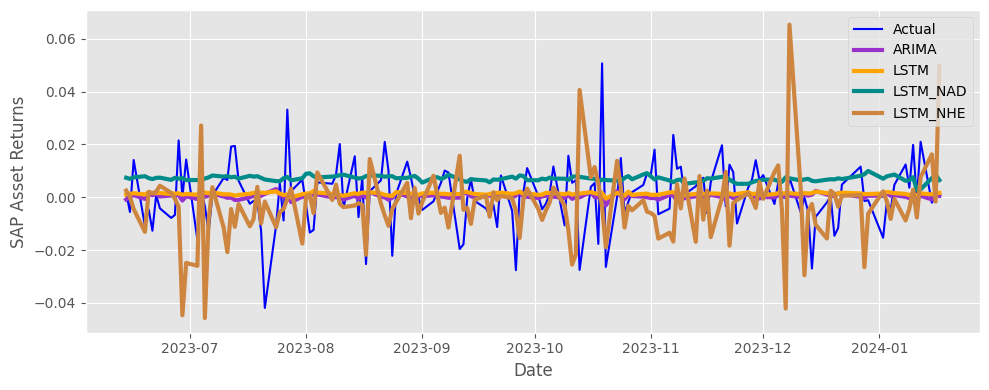

In [124]:
# Assuming results_comp['SAP_DE'] has a DateTimeIndex or the date information can be extracted
# Ensure the index is in DateTime format
if not isinstance(results_comp['SAP_DE'].index, pd.DatetimeIndex):
    results_comp['SAP_DE'].index = pd.to_datetime(results_comp['SAP_DE'].index)

dates = results_comp['SAP_DE'].index  # Extract the dates corresponding to your data

# Plot - SAP asset return predictions
plt.figure(figsize=(10, 4)) 
plt.plot(dates, results_comp['SAP_DE']['actual'], color='blue', label='Actual')
plt.plot(dates, results_comp['SAP_DE']['pred_arima'], color='darkorchid', label='ARIMA', linewidth=3)
plt.plot(dates, results_comp['SAP_DE']['pred_lstm'], color='orange', label='LSTM', linewidth=3)
plt.plot(dates, results_comp['SAP_DE']['pred_lstm_nad'], color='darkcyan', label='LSTM_NAD', linewidth=3)
plt.plot(dates, results_comp['SAP_DE']['pred_lstm_nhe'], color='peru', label='LSTM_NHE', linewidth=3)

# Set major ticks format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Month
#plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability

plt.xlabel('Date')
plt.ylabel('SAP Asset Returns')
plt.legend()
plt.tight_layout()
plt.show()